# import modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import missingno as msno
import os
from datetime import datetime, timedelta
import datetime as dt
import missingno as msn
import re #파이썬에서 정규 표현식을 지원하는 모듈

from functools import partial #데이터프레임에서 다중 컬럼을 이용하여 map or apply 사용을 위해 함수 조건 적용
from dateutil.relativedelta import relativedelta # sql add_month와 유사 역할
from matplotlib.gridspec import GridSpec

import nltk
from nltk import sent_tokenize #문장 토큰화
from nltk import word_tokenize #단어 토큰화
from sklearn.feature_extraction.text import CountVectorizer #사용자가 직정 정의한 불용어 처리
from collections import Counter#워드클라우드를 위해 단어별 빈도수 계산
from wordcloud import WordCloud

from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score ,classification_report,f1_score, confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold

plt.rc("font",family = "Malgun Gothic")
plt.rc("axes",unicode_minus = False)

warnings.filterwarnings(action = "ignore")
pd.options.display.max_rows=100
pd.options.display.max_columns = 100

# load files

In [2]:
next(os.walk("./data"))
# import os;os.listdir('./data')

('./data',
 ['.ipynb_checkpoints'],
 ['NATIONAL REPORT ON E-COMMERCE.pdf',
  'olist_closed_deals_dataset.csv',
  'olist_customers_dataset.csv',
  'olist_geolocation_dataset.csv',
  'olist_marketing_qualified_leads_dataset.csv',
  'olist_orders_dataset.csv',
  'olist_order_items_dataset.csv',
  'olist_order_payments_dataset.csv',
  'olist_order_reviews_dataset.csv',
  'olist_order_reviews_dataset_translate.csv',
  'olist_products_dataset.csv',
  'olist_sellers_dataset.csv',
  'product_category_name_translation.csv'])

In [3]:
product_category_name_translation = pd.read_csv("./data/product_category_name_translation.csv")
olist_products = pd.read_csv("./data/olist_products_dataset.csv")
olist_order_items = pd.read_csv("./data/olist_order_items_dataset.csv")
olist_sellers = pd.read_csv("./data/olist_sellers_dataset.csv")
olist_orders = pd.read_csv("./data/olist_orders_dataset.csv")
olist_customers = pd.read_csv("./data/olist_customers_dataset.csv")
olist_order_payments = pd.read_csv("./data/olist_order_payments_dataset.csv")
olist_order_reviews = pd.read_csv("./data/olist_order_reviews_dataset_translate.csv")
olist_geolocation = pd.read_csv("./data/olist_geolocation_dataset.csv")

## overview

In [4]:
#각 데이터셋을 다루기 위한 list 생성
datasets = [product_category_name_translation, olist_products, olist_order_items, olist_sellers,
           olist_orders, olist_customers, olist_order_payments, olist_order_reviews, olist_geolocation]
dataset_names = ["product_category_name_translation", "olist_products", "olist_order_items", "olist_sellers",
                 "olist_orders", "olist_customers", "olist_order_payments", "olist_order_reviews", "olist_geolocation"]

#필요한 기술통계적 수치를 보기 위한 데이터프레임 생성
data_info = pd.DataFrame({})
data_info['dataset'] = dataset_names
data_info['n_row'] = [df.shape[0] for df in datasets]
data_info['n_col'] = [df.shape[1] for df in datasets]
data_info['null_amount'] = [df.isnull().sum().sum() for df in datasets]
data_info['null_cols_amount'] = [(df.isnull().sum()>1).sum() for df in datasets]
data_info['null_columns'] = [', '.join([col for col,null in df.isnull().sum().items() if null > 0]) for df in  datasets]

data_info.style.background_gradient()

,dataset,n_row,n_col,null_amount,null_cols_amount,null_columns
0,product_category_name_translation,71,2,0,0,
1,olist_products,32951,9,2448,8,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
2,olist_order_items,112650,7,0,0,
3,olist_sellers,3095,4,0,0,
4,olist_orders,99441,8,4908,3,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
5,olist_customers,99441,5,0,0,
6,olist_order_payments,103886,5,0,0,
7,olist_order_reviews,100000,8,204807,3,"review_comment_title, review_comment_message, review_comment_msg_en"
8,olist_geolocation,1000163,5,0,0,


In [5]:
df_overview = pd.DataFrame({})
name_df = []
name_col = []
null_ratio = []
dtype = []
cat_nunique = []
for name, df in zip(dataset_names, datasets):
    name_df += [name] * df.shape[1]
    name_col += [col for col in df.columns]
    null_ratio += [round(num /df.shape[0] * 100,2) for num in df.isnull().sum()]
    cat_nunique += [unique if type(unique) == int else 0 for unique in df.describe(include = "all").T.unique.tolist()]
    dtype +=[dtype for dtype in df.dtypes]

df_overview['dataset_name'] = name_df
df_overview['feature'] = name_col
df_overview["percent_null"] = null_ratio
df_overview["dtype"] = dtype
df_overview["cat_nunique"] = cat_nunique
df_overview

,dataset_name,feature,percent_null,dtype,cat_nunique
0,product_category_name_translation,product_category_name,0.00,object,71
1,product_category_name_translation,product_category_name_english,0.00,object,71
2,olist_products,product_id,0.00,object,32951
3,olist_products,product_category_name,1.85,object,73
4,olist_products,product_name_lenght,1.85,float64,0
5,olist_products,product_description_lenght,1.85,float64,0
6,olist_products,product_photos_qty,1.85,float64,0
7,olist_products,product_weight_g,0.01,float64,0
8,olist_products,product_length_cm,0.01,float64,0
9,olist_products,product_height_cm,0.01,float64,0


# 데이터셋별 전처리

## olist_products + product_category_name_translation
**포르투갈어로 되어 있는 상품명을 영문으로 변환**

In [6]:
olist_products_replace_cat_name = olist_products.copy()

#상품명 통일
olist_products_replace_cat_name.loc[olist_products_replace_cat_name.product_category_name.str.contains("^portateis")==True,"product_category_name"] = "portateis_casa_forno_e_cafe"
olist_products_replace_cat_name.loc[olist_products_replace_cat_name.product_category_name.str.contains("^pc")==True,"product_category_name"] = "pcs"

#상품명 영어로 변환
olist_products_eng = pd.merge(olist_products_replace_cat_name, product_category_name_translation, on = "product_category_name", how = "left")

## category_name 중분류로 대체

In [7]:
#상품 상위 분류 컬럼 생성
category_rename = {"cool_stuff":"stationery",
"pet_shop":"pet",
"furniture_decor":"furniture",
"perfumery":"beauty",
"garden_tools":"garden_tools",
"housewares":"home_appliances",
"telephony":"telephone",
"health_beauty":"beauty",
"books_technical":"book",
"fashion_bags_accessories":"fashion",
"bed_bath_table":"home_living",
"sports_leisure":"sports",
"consoles_games":"games",
"office_furniture":"furniture",
"luggage_accessories":"stationery",
"food":"food_drink",
"agro_industry_and_commerce":"agro",
"electronics":"electronics",
"computers_accessories":"electronics",
"construction_tools_construction":"construction",
"audio":"electronics",
"baby":"baby",
"construction_tools_lights":"construction",
"toys":"stationery",
"stationery":"stationery",
"industry_commerce_and_business":"others",
"watches_gifts":"stationery",
"auto":"auto",
"home_appliances":"home_appliances",
"kitchen_dining_laundry_garden_furniture":"home_living",
"air_conditioning":"electronics",
"home_confort":"home_living",
"fixed_telephony":"telephone",
"small_appliances_home_oven_and_coffee":"home_appliances",
"diapers_and_hygiene":"home_living",
"signaling_and_security":"security",
"musical_instruments":"culture",
"small_appliances":"home_appliances",
"costruction_tools_garden":"garden_tools",
"art":"culture",
"home_construction":"construction",
"books_general_interest":"book",
"party_supplies":"stationery",
"construction_tools_safety":"construction",
"cine_photo":"culture",
"fashion_underwear_beach":"fashion",
"food_drink":"food_drink",
"drinks":"food_drink",
"furniture_living_room":"furniture",
"market_place":"others",
"music":"culture",
"fashion_shoes":"fashion",
"flowers":"agro",
"home_appliances_2":"home_appliances",
"fashio_female_clothing":"fashion",
"fashion_male_clothing":"fashion",
"computers":"electronics",
"books_imported":"book",
"christmas_supplies":"stationery",
"furniture_bedroom":"furniture",
"home_comfort_2":"home_living",
"dvds_blu_ray":"culture",
"cds_dvds_musicals":"culture",
"arts_and_craftmanship":"culture",
"furniture_mattress_and_upholstery":"furniture",
"tablets_printing_image":"electronics",
"costruction_tools_tools":"construction",
"fashion_sport":"fashion",
"la_cuisine":"food_drink",
"security_and_services":"security",
"fashion_childrens_clothes":"fashion"}

#rename df 생성
df_cat_rename = pd.DataFrame({"product_category_name_english" : category_rename.keys(), "product_category_upper" : category_rename.values()})

#기존 dataset에 중분류 합치기
olist_products_rename = olist_products_eng.merge(df_cat_rename,on = "product_category_name_english", how = "left")

In [8]:
olist_products_rename.head(1)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,product_category_upper
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery,beauty


## olist_order_items :  total_payment 컬럼 생성
**olist_order_payments에 payment_value(상품가격 + 배송비)가 있으나,  
해당 컬럼 값이 집계가 잘못되어 직접 상품가격 + 배송비를 계산하여 컬럼으로 생성**

In [9]:
olist_order_items["total_payment"] = olist_order_items["price"]+olist_order_items["freight_value"]
olist_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,total_payment
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,72.19
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,259.83
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,216.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,218.04


## olist_order_items : order_id별 상품명 및 판매자 중복 행 합치기
**한 구매 건수(order_id)에 동일한 상품이 여러 개의 관측치로 나눠져 있는 경우 하나로 합치고,
상품별 개수를 따로 지정**

In [10]:
olist_order_items[olist_order_items.order_id=="ca3625898fbd48669d50701aba51cd5f"]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,total_payment
89007,ca3625898fbd48669d50701aba51cd5f,1,1065e0ebef073787a7bf691924c60eeb,0b35c634521043bf4b47e21547b99ab5,2018-08-16 02:25:07,309.0,1.84,310.84
89008,ca3625898fbd48669d50701aba51cd5f,2,0cf2faf9749f53924cea652a09d8e327,0b35c634521043bf4b47e21547b99ab5,2018-08-16 02:25:07,33.9,1.84,35.74
89009,ca3625898fbd48669d50701aba51cd5f,3,0de59eddc63167215c972b0d785ffa7b,0b35c634521043bf4b47e21547b99ab5,2018-08-16 02:25:07,159.0,3.67,162.67
89010,ca3625898fbd48669d50701aba51cd5f,4,0de59eddc63167215c972b0d785ffa7b,0b35c634521043bf4b47e21547b99ab5,2018-08-16 02:25:07,159.0,3.67,162.67
89011,ca3625898fbd48669d50701aba51cd5f,5,5dae498eff2d80057f56122235a36aff,888faa8bfb0b159c37de6d898b961c31,2018-08-17 02:25:07,95.9,0.15,96.05
89012,ca3625898fbd48669d50701aba51cd5f,6,4a5c3967bfd3629fe07ef4d0cc8c3818,0b35c634521043bf4b47e21547b99ab5,2018-08-16 02:25:07,109.9,0.15,110.05
89013,ca3625898fbd48669d50701aba51cd5f,7,678c229b41c0e497d35a25a8be1cc631,888faa8bfb0b159c37de6d898b961c31,2018-08-17 02:25:07,95.9,0.15,96.05
89014,ca3625898fbd48669d50701aba51cd5f,8,21b524c4c060169fa75ccf08c7da4627,0b35c634521043bf4b47e21547b99ab5,2018-08-16 02:25:07,63.7,0.15,63.85
89015,ca3625898fbd48669d50701aba51cd5f,9,309dd69eb83cea38c51709d62befe1a4,0b35c634521043bf4b47e21547b99ab5,2018-08-16 02:25:07,56.0,3.68,59.68
89016,ca3625898fbd48669d50701aba51cd5f,10,309dd69eb83cea38c51709d62befe1a4,0b35c634521043bf4b47e21547b99ab5,2018-08-16 02:25:07,56.0,3.68,59.68


In [11]:
olist_order_items_temp = olist_order_items.groupby(["order_id","product_id","seller_id"])\
.agg({"order_item_id" : "count", "total_payment" : "sum", "freight_value" : "sum"})\
.reset_index().rename(columns = {"order_item_id" : "item_nb"})
olist_order_items_temp[olist_order_items_temp.order_id=="ca3625898fbd48669d50701aba51cd5f"]

,order_id,product_id,seller_id,item_nb,total_payment,freight_value
80867,ca3625898fbd48669d50701aba51cd5f,0cf2faf9749f53924cea652a09d8e327,0b35c634521043bf4b47e21547b99ab5,1,35.74,1.84
80868,ca3625898fbd48669d50701aba51cd5f,0de59eddc63167215c972b0d785ffa7b,0b35c634521043bf4b47e21547b99ab5,2,325.34,7.34
80869,ca3625898fbd48669d50701aba51cd5f,1065e0ebef073787a7bf691924c60eeb,0b35c634521043bf4b47e21547b99ab5,1,310.84,1.84
80870,ca3625898fbd48669d50701aba51cd5f,21b524c4c060169fa75ccf08c7da4627,0b35c634521043bf4b47e21547b99ab5,1,63.85,0.15
80871,ca3625898fbd48669d50701aba51cd5f,309dd69eb83cea38c51709d62befe1a4,0b35c634521043bf4b47e21547b99ab5,2,119.36,7.36
80872,ca3625898fbd48669d50701aba51cd5f,4a5c3967bfd3629fe07ef4d0cc8c3818,0b35c634521043bf4b47e21547b99ab5,1,110.05,0.15
80873,ca3625898fbd48669d50701aba51cd5f,5dae498eff2d80057f56122235a36aff,888faa8bfb0b159c37de6d898b961c31,1,96.05,0.15
80874,ca3625898fbd48669d50701aba51cd5f,678c229b41c0e497d35a25a8be1cc631,888faa8bfb0b159c37de6d898b961c31,1,96.05,0.15


## olist_order_items : freight_value_rate 컬럼 생성
**판매액 중 배송비 비율 컬럼 생성**

In [12]:
olist_order_items_temp["freight_value_rate"] = (olist_order_items_temp["freight_value"] / olist_order_items_temp["total_payment"]*100).round(2)
olist_order_items_temp.head()

,order_id,product_id,seller_id,item_nb,total_payment,freight_value,freight_value_rate
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,1,72.19,13.29,18.41
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,1,259.83,19.93,7.67
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,1,216.87,17.87,8.24
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,1,25.78,12.79,49.61
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,1,218.04,18.14,8.32


## olist_order_payments : order_id별 payment_value만 남기고 모두 삭제
**해당 데이터셋에선 payment_value와 order_id 컬럼만 사용할 예정이므로, order_id 기준으로 데이터 집계**

In [13]:
olist_order_payments.head(2)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39


In [14]:
olist_order_payments_temp = olist_order_payments.groupby("order_id").payment_value.sum().reset_index().copy()
olist_order_payments_temp.head(1)

,order_id,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,72.19


## olist_order_reviews : 데이터 확인
**특정 구매 건(order_id)의 경우 review가 여러 개 달린 게 있는데, 이 부분은 전체 dataset을 merge 후 구매 건마다 review가 2개 이상인 경우 제거**

In [15]:
olist_order_reviews.order_id.value_counts().reset_index().head(10)

,index,order_id
0,c88b1d1b157a9999ce368f218a407141,3
1,8e17072ec97ce29f0e1f111e598b0c85,3
2,03c939fd7fd3b38f8485a0f95798f1f6,3
3,df56136b8031ecd28e200bb18e6ddb2e,3
4,9de38c42ea4d33af19aac6c4d6c4b146,2
5,687297c4cb20d6fad502624bed7376ec,2
6,b48681f5e795989ee7e78953269720e2,2
7,2b0e07b3ff6d3a2db9405022edc865c2,2
8,42ae1967f68c90bb325783ac55d761ce,2
9,25cb912c6742e486c6988aaf2c8f221b,2


In [16]:
olist_order_reviews[olist_order_reviews.order_id=="03c939fd7fd3b38f8485a0f95798f1f6"]

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,review_comment_msg_en
8329,b04ed893318da5b863e878cd3d0511df,03c939fd7fd3b38f8485a0f95798f1f6,3,NaN,Um ponto negativo que achei foi a cobrança de ...,2018-03-20 0:00,2018-03-21 2:28,A negative point I found was the collection of...
51931,f4bb9d6dd4fb6dcc2298f0e7b17b8e1e,03c939fd7fd3b38f8485a0f95798f1f6,4,NaN,NaN,2018-03-29 0:00,2018-03-30 0:29,NaN
70005,405eb2ea45e1dbe2662541ae5b47e2aa,03c939fd7fd3b38f8485a0f95798f1f6,3,NaN,Seria ótimo se tivesem entregue os 3 (três) pe...,2018-03-06 0:00,2018-03-06 19:50,It would be great if they had delivered the 3 ...


In [17]:
olist_orders[olist_orders.order_id=="03c939fd7fd3b38f8485a0f95798f1f6"]
# olist_order_items[olist_order_items.order_id=="03c939fd7fd3b38f8485a0f95798f1f6"]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
12362,03c939fd7fd3b38f8485a0f95798f1f6,2a35ad9f439dfc62d35a0202e71d6c66,delivered,2018-02-25 21:01:08,2018-02-26 09:35:46,2018-02-26 22:46:40,2018-03-19 21:48:52,2018-04-02 00:00:00


### review_comment 길이 생성

In [18]:
olist_order_reviews["review_comment_length"] = olist_order_reviews["review_comment_message"].map(lambda x : len(x) if type(x)==str else 0)
olist_order_reviews.head(10)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,review_comment_msg_en,review_comment_length
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 0:00,2018-01-18 21:46,NaN,0
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 0:00,2018-03-11 3:05,NaN,0
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 0:00,2018-02-18 14:36,NaN,0
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 0:00,2017-04-21 22:02,I received well before the stipulated deadline.,37
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 0:00,2018-03-02 10:26,Congratulations LANNISTER stores I loved to bu...,100
5,15197aa66ff4d0650b5434f1b46cda19,b18dcdf73be66366873cd26c5724d1dc,1,NaN,NaN,2018-04-13 0:00,2018-04-16 0:39,NaN,0
6,07f9bee5d1b850860defd761afa7ff16,e48aa0d2dcec3a2e87348811bcfdf22b,5,NaN,NaN,2017-07-16 0:00,2017-07-18 19:30,NaN,0
7,7c6400515c67679fbee952a7525281ef,c31a859e34e3adac22f376954e19b39d,5,NaN,NaN,2018-08-14 0:00,2018-08-14 21:36,NaN,0
8,a3f6f7f6f433de0aefbb97da197c554c,9c214ac970e84273583ab523dfafd09b,5,NaN,NaN,2017-05-17 0:00,2017-05-18 12:05,NaN,0
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22 0:00,2018-05-23 16:45,efficient device. on the site the mark of the ...,174


## Olist_geolocation

### geolocation_state 이상치 처리
---
실제 zipcode의 state와 다른 state로 작성된 부분 수정

In [19]:
#zipcode별로 state 개수 확인
zip_code = olist_geolocation[["geolocation_zip_code_prefix","geolocation_state"]].drop_duplicates()\
.groupby(["geolocation_zip_code_prefix"]).geolocation_state.count().sort_values().reset_index()
zip_code

,geolocation_zip_code_prefix,geolocation_state
0,1001,1
1,62010,1
2,62000,1
3,61979,1
4,61962,1
...,...,...
19010,79750,2
19011,2116,2
19012,80630,2
19013,4011,2


In [20]:
#zipcode별 state가 2개인 데이터셋 
zipcode = zip_code[zip_code.geolocation_state>1].geolocation_zip_code_prefix.tolist()
zipcode

[23056, 78557, 21550, 79750, 2116, 80630, 4011, 72915]

In [21]:
for loc in zipcode:
    #zipcode별 state명 빈도수가 많은 이름 state 선택
    set_states = olist_geolocation[olist_geolocation.geolocation_zip_code_prefix==loc]\
    .groupby("geolocation_state").geolocation_zip_code_prefix.count().sort_values().index[-1]
    
    #zipcode별 state 통일
    olist_geolocation.loc[olist_geolocation.geolocation_zip_code_prefix==loc,"geolocation_state"] = set_states

In [22]:
zip_code = olist_geolocation[["geolocation_zip_code_prefix","geolocation_state"]].drop_duplicates()\
.groupby(["geolocation_zip_code_prefix"]).geolocation_state.count().sort_values().reset_index()
zip_code

,geolocation_zip_code_prefix,geolocation_state
0,1001,1
1,62014,1
2,62011,1
3,62010,1
4,62000,1
...,...,...
19010,19908,1
19011,19907,1
19012,19906,1
19013,19904,1


### zipcode, city, state로 groupby하여 lat,lng의 중간 위치 구하기
**geolocation_zip_code별로 하나의 위경도 값만 남기기 위해 zip_code 기준으로 groupby**

In [23]:
olist_geolocation.sort_values("geolocation_zip_code_prefix")

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
1246,1001,-23.549292,-46.633559,sao paulo,SP
429,1001,-23.550498,-46.634338,sao paulo,SP
1182,1001,-23.549779,-46.633957,sao paulo,SP
1435,1001,-23.549292,-46.633559,sao paulo,SP
326,1001,-23.551427,-46.634074,sao paulo,SP
...,...,...,...,...,...
1000026,99980,-28.388679,-51.848863,david canabarro,RS
999950,99980,-28.388400,-51.845225,david canabarro,RS
1000002,99980,-28.388342,-51.845194,david canabarro,RS
999864,99990,-28.329472,-51.769109,muliterno,RS


In [24]:
# olist_geolocation["geolocation_zip_code_prefix"]=olist_geolocation.geolocation_zip_code_prefix.astype(str)
olist_geolocation_mean = olist_geolocation.groupby(["geolocation_zip_code_prefix","geolocation_state"])\
                         [["geolocation_lat","geolocation_lng"]].mean().reset_index()
olist_geolocation_mean.head(2)

,geolocation_zip_code_prefix,geolocation_state,geolocation_lat,geolocation_lng
0,1001,SP,-23.550190,-46.634024
1,1002,SP,-23.548146,-46.634979


# merge all

**1-1. olist_products_eng = olist_products_replace_cat_name + product_category_name_translation  
1-2. olist_products_rename = olist_products_eng + 중분류  
2. temp0 = olist_order_items + olist_products_rename  
3-1. olist_sellers_geo = olist_sellers + olist_geolocation  
3-2. temp1 = olist_sellers_geo + olist_order_items  
4. temp2 = temp1 + olist_orders  
5-1. olist_customers_geo = olist_customer + olist_geolocation  
5-2. temp3 = temp2 + olist_customers_geo  
6. temp4 = temp3 + olist_order_payments  
7. temp5 = temp4 + olist_order_reviews_mean**

In [25]:
olist_sellers_geo = pd.merge(olist_sellers,olist_geolocation_mean,left_on = ["seller_zip_code_prefix"],
        right_on = ["geolocation_zip_code_prefix"],how = "left")

olist_customers_geo = pd.merge(olist_customers,olist_geolocation_mean,left_on = ["customer_zip_code_prefix"],
        right_on = ["geolocation_zip_code_prefix"],how = "left")

temp0 = pd.merge(olist_order_items_temp,olist_products_rename,on="product_id",how="outer")

temp1 = pd.merge(temp0,olist_sellers_geo,on="seller_id",how="outer")
temp1 = temp1.drop(["seller_city","seller_state","seller_zip_code_prefix"],axis=1)
temp1 = temp1.rename(columns = {'geolocation_zip_code_prefix' : "seller_zip_code_prefix",
                                'geolocation_state' : 'seller_state'})

temp2 = pd.merge(temp1,olist_orders,on = "order_id",how = "outer")

temp3 = pd.merge(temp2,olist_customers_geo,on = "customer_id",how = "outer")
temp3 = temp3.drop(["customer_city","customer_state","customer_zip_code_prefix"],axis=1)
temp3 = temp3.rename(columns = {'geolocation_zip_code_prefix' : "customer_zip_code_prefix",
                                'geolocation_state' : 'customer_state'})

temp4 = pd.merge(temp3,olist_order_payments_temp,on = "order_id",how = "outer")

temp5 = pd.merge(temp4,olist_order_reviews,on = "order_id",how = "outer")

df = temp5.copy()
df.head(2)

,order_id,product_id,seller_id,item_nb,total_payment,freight_value,freight_value_rate,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,product_category_upper,seller_zip_code_prefix,seller_state,geolocation_lat_x,geolocation_lng_x,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_state,geolocation_lat_y,geolocation_lng_y,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,review_comment_msg_en,review_comment_length
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,1.0,72.19,13.29,18.41,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,stationery,27277.0,RJ,-22.496953,-44.127492,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,871766c5855e863f6eccc05f988b23cb,28013.0,RJ,-21.762775,-41.309633,72.19,97ca439bc427b48bc1cd7177abe71365,5,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21 0:00,2017-09-22 10:57,"Perfect, product delivered before the agreed.",46
1,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,1.0,73.86,17.96,24.32,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,stationery,27277.0,RJ,-22.496953,-44.127492,e6eecc5a77de221464d1c4eaff0a9b64,delivered,2017-06-28 11:52:20,2017-06-29 02:44:11,2017-07-05 12:00:33,2017-07-13 20:39:29,2017-07-26 00:00:00,0fb8e3eab2d3e79d92bb3fffbb97f188,75800.0,GO,-17.884337,-51.716990,73.86,b11cba360bbe71410c291b764753d37f,5,NaN,"lannister como sempre, entregou certinho e den...",2017-07-14 0:00,2017-07-17 12:50,"Lannister as always, delivered right and withi...",75


## 데이터 타입 변경

In [26]:
date_type_cols =\
['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date',
'order_estimated_delivery_date','review_creation_date','review_answer_timestamp']

df[date_type_cols] = df[date_type_cols].apply(pd.to_datetime)

## 시간대별 컬럼 생성

In [27]:
df["order_purchase_time"] = df.order_purchase_timestamp.map(lambda x : dt.datetime(x.year, x.month,x.day))
df["year_month"] = df.order_purchase_timestamp.map(lambda x : dt.datetime(x.year, x.month,1))
df["year"] = df.order_purchase_timestamp.dt.year
df["month"] = df.order_purchase_timestamp.dt.month
df["month_name"] = df.order_purchase_timestamp.dt.month_name().map(lambda x : x[:3])
df["week"] = df.order_purchase_timestamp.dt.weekday
df["day"] = df.order_purchase_timestamp.dt.day
df["dayofweek"] = df.order_purchase_timestamp.dt.day_name().map(lambda x: x[:3])
df["hour"] = df.order_purchase_timestamp.dt.hour

# exploratory Data Analysis

## order_status 빈도수

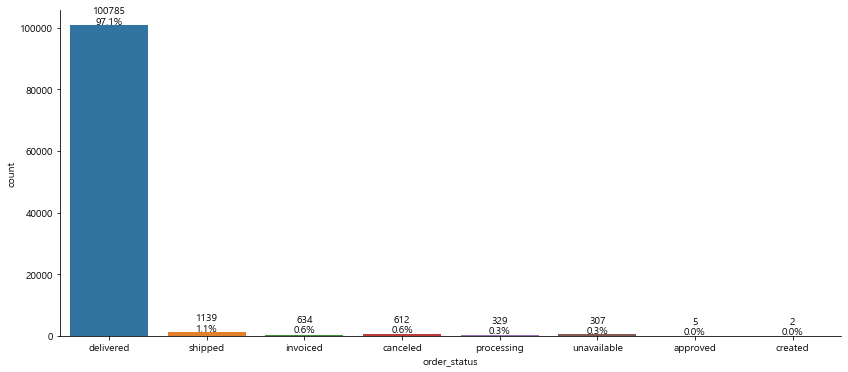

In [28]:
fig,ax = plt.subplots(figsize = (14,6))
sns.countplot(data = df, x = "order_status",ax=ax)

for index, num in enumerate(df.order_status.value_counts()):
    ax.annotate(s = f"{num}\n{num/df.shape[0]*100:.1f}%",
                xy = [index, num+3000],
               va = "center", ha = "center")
sns.despine()

- 전체 주문 건수에서 배송 완료된 비율이 약 97%인 것을 확인

## 시기별 판매건수

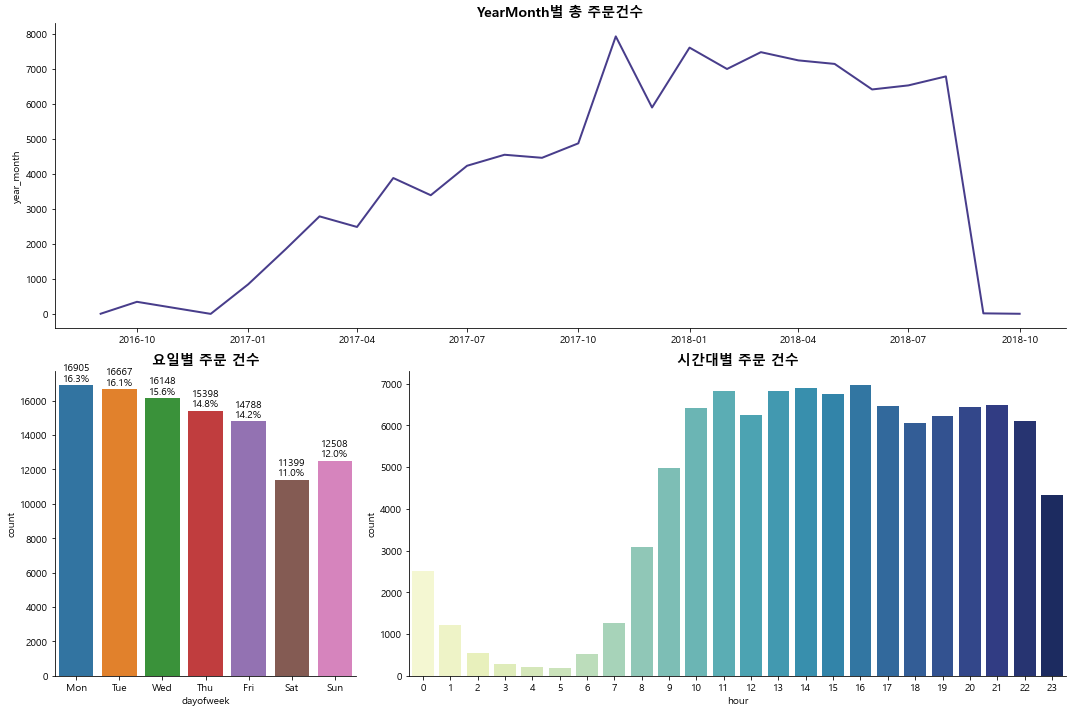

In [29]:
fig= plt.figure(figsize=(15, 10))
gs = GridSpec(2,3, figure = fig)
ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1,:1])
ax3 = fig.add_subplot(gs[1,1:])


#년월별 매출건수
sns.lineplot(data = df.year_month.value_counts().sort_index(), ax = ax1, color = 'darkslateblue', linewidth = 2)
ax1.set_title("YearMonth별 총 주문건수", size = 14, fontweight = "bold")

#요일별 매출건수
dayofweek_sorted = ['Mon', 'Tue','Wed', 'Thu','Fri', 'Sat', 'Sun']
sns.countplot(data = df, x =  "dayofweek",order =dayofweek_sorted ,ax = ax2)

dayofweek_sorted_dict = {'Mon':0, 'Tue':1,'Wed':2, 'Thu':3,'Fri':4, 'Sat':5,'Sun':6}
for s,num in df.dayofweek.value_counts().items():
    ax2.annotate(s = f"{num}\n{num/df.shape[0]*100:.1f}%",
                xy = [dayofweek_sorted_dict[s], num+700], va = 'center', ha = 'center')
ax2.set_title("요일별 주문 건수",size = 14, fontweight= "bold")

#시간대별 매출 건수
sns.countplot(data = df, x = "hour", ax = ax3, palette = 'YlGnBu')
ax3.set_title("시간대별 주문 건수",size = 14, fontweight= "bold")

# df.dayofweek.value_counts()
sns.despine()
plt.tight_layout()

- 주문건수가 일부 문제가 있는 것으로 보여 17.1~18.8 데이터만 사용하기로 함

In [30]:
start_date = dt.date(2017,1,1)
end_date = dt.date(2018,9,1)
print(f"16.9~18.9 : {df.shape}")
df = df[(df.order_purchase_timestamp.dt.date >= start_date) &
        (df.order_purchase_timestamp.dt.date < end_date)].reset_index(drop=True)
print(f"17.1~18.8 : {df.shape}")

16.9~18.9 : (103813, 51)
17.1~18.8 : (103441, 51)


## 동기간 olist 성장률

(1~8월 기준)17년도 총 주문 건수 : 24034
(1~8월 기준)18년도 총 주문 건수 : 56233
(1~8월 기준)17년도 대비 18년도 주문건수 증감율 : 134%


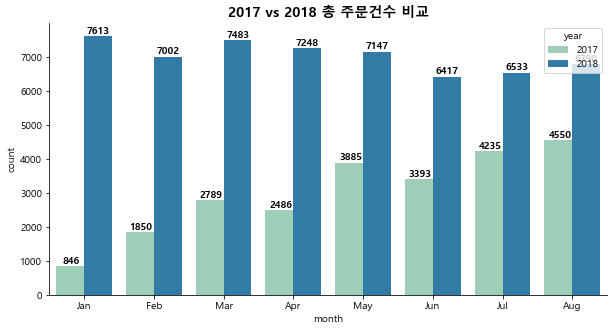

In [31]:
df_temp = df[df.month <=8].copy()
fig,ax = plt.subplots(figsize = (10,5))
sns.countplot(data = df_temp, x = "month",hue = "year",palette="YlGnBu", ax=ax)

print(f"(1~8월 기준)17년도 총 주문 건수 : {df_temp[df_temp.year==2017].month_name.shape[0]}")
print(f"(1~8월 기준)18년도 총 주문 건수 : {df_temp[df_temp.year==2018].month_name.shape[0]}")
print(f"(1~8월 기준)17년도 대비 18년도 주문건수 증감율 : {int(round((df_temp[df_temp.year==2018].month_name.shape[0]-df_temp[df_temp.year==2017].month_name.shape[0])/df_temp[df_temp.year==2017].month_name.shape[0]*100,1))}%")

month_label = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
month_label_dict = {'Jan':0, 'Feb':1, 'Mar':2, 'Apr':3, 'May':4, 'Jun':5, 'Jul':6, 'Aug':7}
ax.set_xticklabels(month_label)
for s,num in df_temp[df_temp.year==2017].month_name.value_counts().items():
    ax.annotate(s = f"{num}",
                xy = [month_label_dict[s]-0.18, num+150], va = 'center', ha = 'center', fontweight = "bold")

for s,num in df_temp[df_temp.year==2018].month_name.value_counts().items():
    ax.annotate(s = f"{num}",
                xy = [month_label_dict[s]+0.2, num+150], va = 'center', ha = 'center', fontweight = "bold")
ax.set_title("2017 vs 2018 총 주문건수 비교", size = 14, fontweight = "bold")
sns.despine()
plt.show()

## 상품 카테고리별 수요량

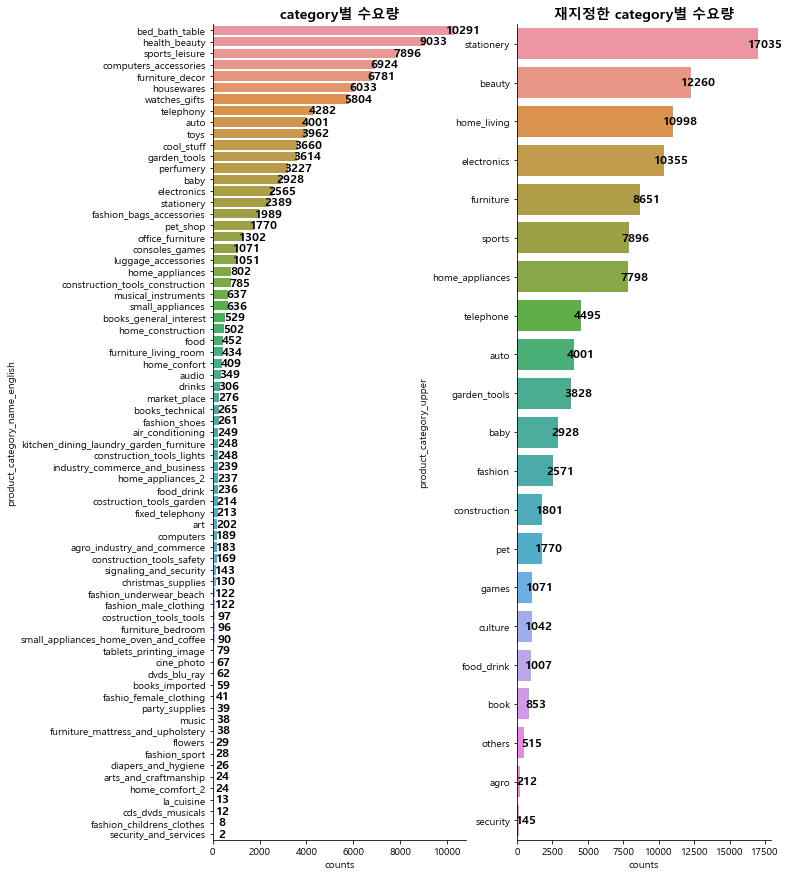

In [32]:
fig,ax = plt.subplots(1,2,figsize = (10,15))

plot_data1 = df.product_category_name_english.value_counts().reset_index()
plot_data1.columns = ["product_category_name_english","counts"]
plot_data1 = plot_data1.sort_values("counts", ascending = False)
sns.barplot(data = plot_data1, x = "counts", y="product_category_name_english", ax = ax[0])
for s in plot_data1.index:
    ax[0].annotate(s = f"{plot_data1.loc[s,'counts']}",
              xy = (plot_data1.loc[s,'counts']+400,s),
              va = "center",ha = "center", fontweight = "bold",fontsize = 12)
ax[0].set_title("category별 수요량", size = 14, fontweight = "bold")
    
plot_data2 = df.product_category_upper.value_counts().reset_index()
plot_data2.columns = ["product_category_upper","counts"]
plot_dat2a = plot_data2.sort_values("counts", ascending = False)
sns.barplot(data = plot_data2, x = "counts", y="product_category_upper", ax = ax[1])
for s in plot_data2.index:
    ax[1].annotate(s = f"{plot_data2.loc[s,'counts']}",
              xy = (plot_data2.loc[s,'counts']+500,s),
              va = "center",ha = "center", fontweight = "bold",fontsize = 12)
ax[1].set_title("재지정한 category별 수요량", size = 14, fontweight = "bold")
sns.despine()

## 배송 기간

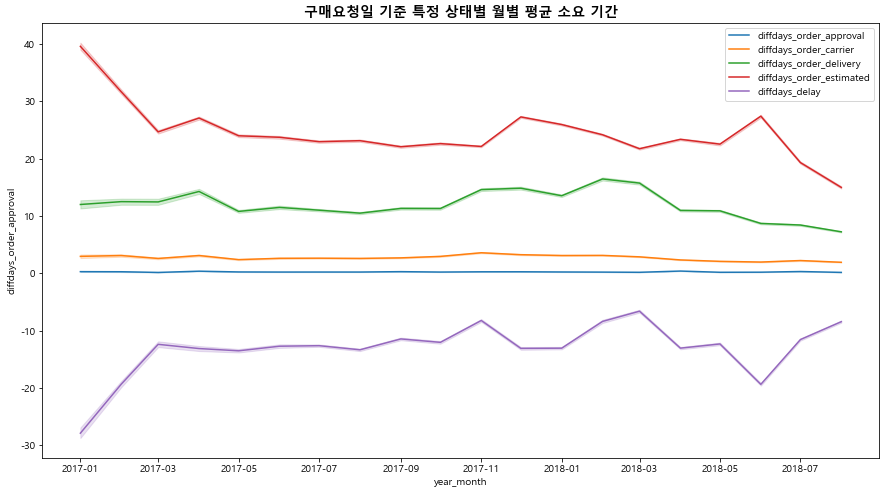

In [33]:
df_delivery = df.copy()
df_delivery["diffdays_order_estimated"] = (df_delivery.order_estimated_delivery_date - df_delivery.order_purchase_timestamp).dt.days
df_delivery["diffdays_order_delivery"] = (df_delivery.order_delivered_customer_date - df_delivery.order_purchase_timestamp).dt.days
df_delivery["diffdays_order_approval"] = (df_delivery.order_approved_at - df_delivery.order_purchase_timestamp).dt.days
df_delivery["diffdays_order_carrier"] = (df_delivery.order_delivered_carrier_date - df_delivery.order_purchase_timestamp).dt.days
df_delivery["diffdays_carrier_delivery"] = (df_delivery.order_delivered_customer_date - df_delivery.order_delivered_carrier_date).dt.days
df_delivery["diffdays_delay"] = (df_delivery.order_delivered_customer_date-df_delivery.order_estimated_delivery_date).dt.days
# df_delivery["diffdays_delay"] = (df_delivery.order_estimated_delivery_date-df_delivery.order_delivered_customer_date).dt.days

fig,ax1 = plt.subplots(1,1,figsize = (15,8))
sns.lineplot(data = df_delivery, x = "year_month", y = "diffdays_order_approval", ax = ax1, label = "diffdays_order_approval")
sns.lineplot(data = df_delivery, x = "year_month", y = "diffdays_order_carrier", ax = ax1, label = "diffdays_order_carrier")
sns.lineplot(data = df_delivery, x = "year_month", y = "diffdays_order_delivery", ax = ax1, label = "diffdays_order_delivery")
sns.lineplot(data = df_delivery, x = "year_month", y = "diffdays_order_estimated", ax = ax1, label = "diffdays_order_estimated")
sns.lineplot(data = df_delivery, x = "year_month", y = "diffdays_delay", ax = ax1, label = "diffdays_delay")


ax1.set_title("구매요청일 기준 특정 상태별 월별 평균 소요 기간", size = 14, fontweight = "bold")
plt.show()

## 구매 횟수별 고객 분포

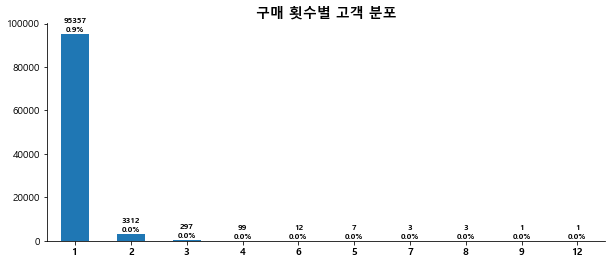

In [34]:
fig,ax = plt.subplots(figsize = (10,4))
df.customer_id.value_counts().value_counts().plot.bar( ax = ax)

for i,s in enumerate(df.customer_id.value_counts().value_counts()):
    ax.annotate(s = f"{s}\n{s/df.shape[0]:.1f}%",
                xy = [i,s+4000], va = 'center',ha = 'center',size = 8, fontweight = "bold")
plt.xticks(rotation = 0, fontweight = "bold")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
ax.set_title("구매 횟수별 고객 분포", fontweight = "bold", size = 14)

plt.show()

## 고객 분포(by 코호트)

In [35]:
def get_cohort_params(df, invoice_date, cohort_date):
    invoice_month = df[invoice_date].dt.month
    invoice_year = df[invoice_date].dt.year
    
    cohort_month = df[cohort_date].dt.month
    cohort_year = df[cohort_date].dt.year
    
    month_diff = invoice_month - cohort_month
    year_diff = invoice_year - cohort_year
    
    cohort_index = (year_diff*12) + month_diff + 1
    return cohort_index

In [36]:
df_temp = df.copy()
df_temp["cohort_month"] = df_temp.groupby("customer_unique_id").year_month.transform("min").apply(pd.to_datetime)
df_temp["cohort_index"] = get_cohort_params(df_temp, "order_purchase_timestamp","cohort_month")

cohort = df_temp.groupby(["cohort_month","cohort_index"]).customer_unique_id.count().unstack()
cohort.index = cohort.index.date

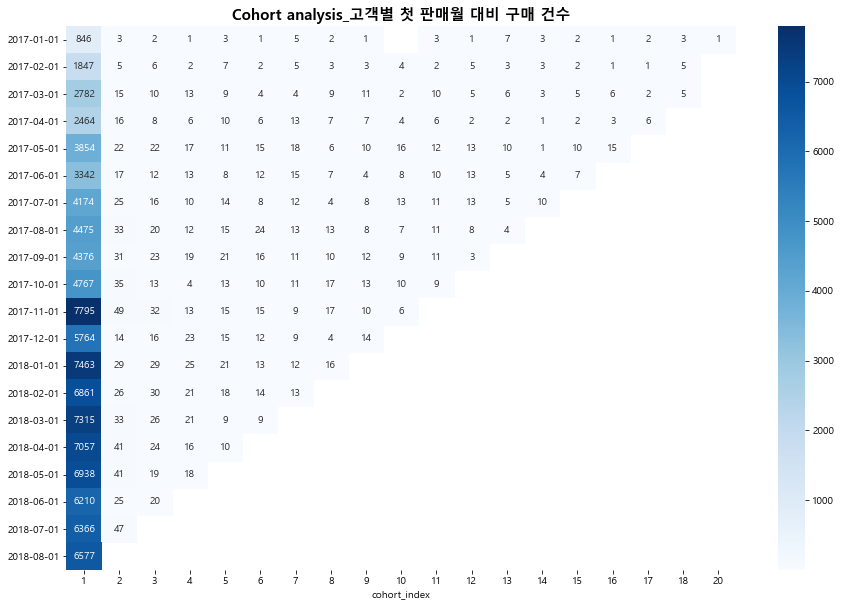

In [37]:
fig,ax = plt.subplots(1,1,figsize = (15,10))
g = sns.heatmap(cohort,cmap = "Blues",ax = ax, annot = True, fmt = ".0f")
g.set_title("Cohort analysis_고객별 첫 판매월 대비 구매 건수", fontsize = 15,fontweight = 'bold')
plt.show()

## 판매자 기준 거래건수 분포 (by 코호트)

In [38]:
df_temp = df.copy()
df_temp["cohort_month"] = df_temp.groupby("seller_id").year_month.transform("min").apply(pd.to_datetime)
df_temp["cohort_index"] = get_cohort_params(df_temp, "order_purchase_timestamp","cohort_month")

cohort = df_temp.groupby(["cohort_month","cohort_index"]).customer_unique_id.count().unstack()
cohort.index = cohort.index.date

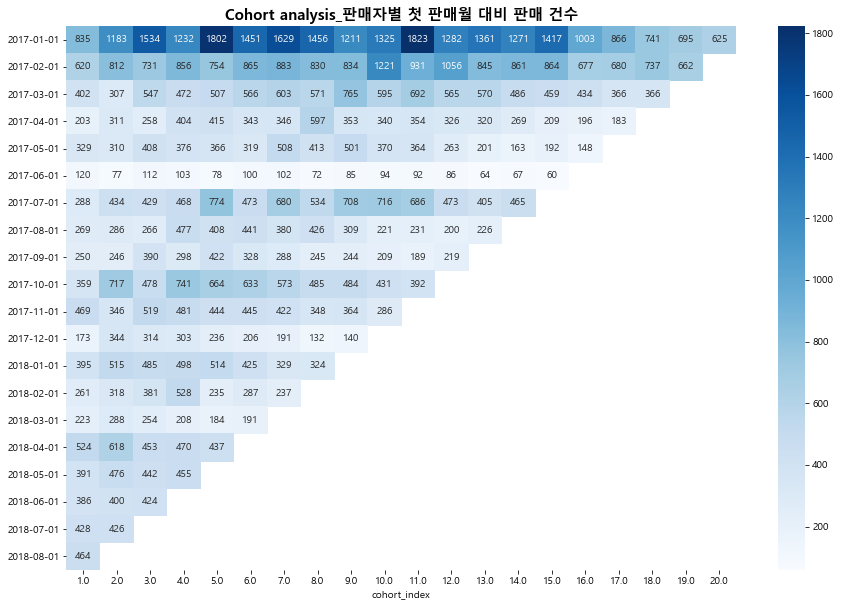

In [39]:
fig,ax = plt.subplots(1,1,figsize = (15,10))
g = sns.heatmap(cohort,cmap = "Blues",ax = ax, annot = True, fmt = ".0f")
g.set_title("Cohort analysis_판매자별 첫 판매월 대비 판매 건수", fontsize = 15,fontweight = 'bold')
plt.show()

## 고객 및 판매자 위치별 구매 건수 및 실제 배송 기간 및 예상 배송 기간

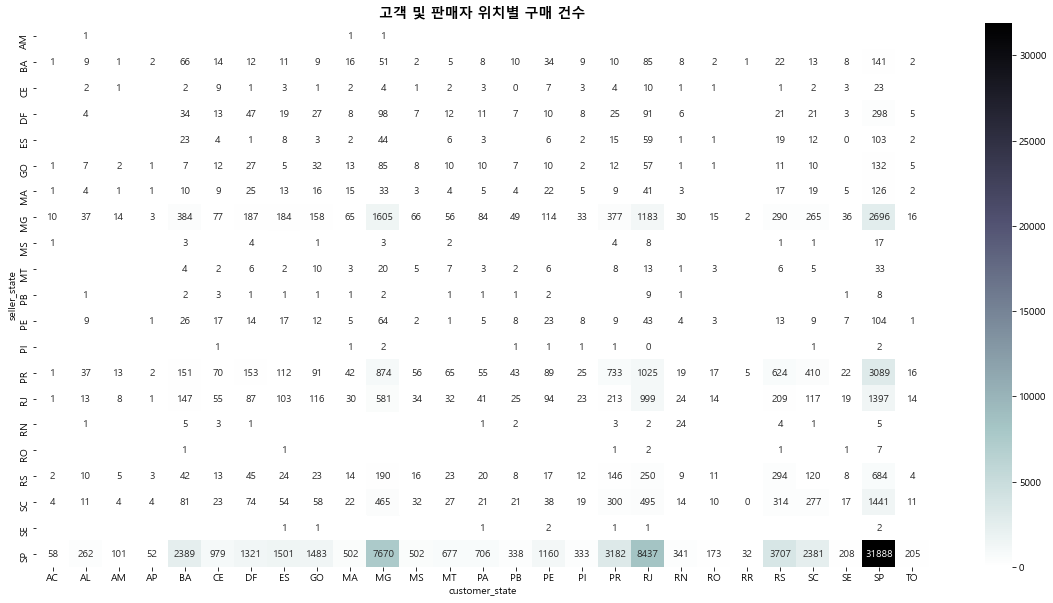

In [40]:
pivottable = pd.pivot_table(data = df_delivery,index = "seller_state", columns = "customer_state", values = "diffdays_order_delivery", aggfunc = "count")

fig,ax = plt.subplots(figsize = (20,10))
sns.heatmap(pivottable,annot = True, fmt='.10g', cmap = plt.cm.bone_r)
ax.set_title("고객 및 판매자 위치별 구매 건수",size = 14, fontweight = "bold")
plt.show()

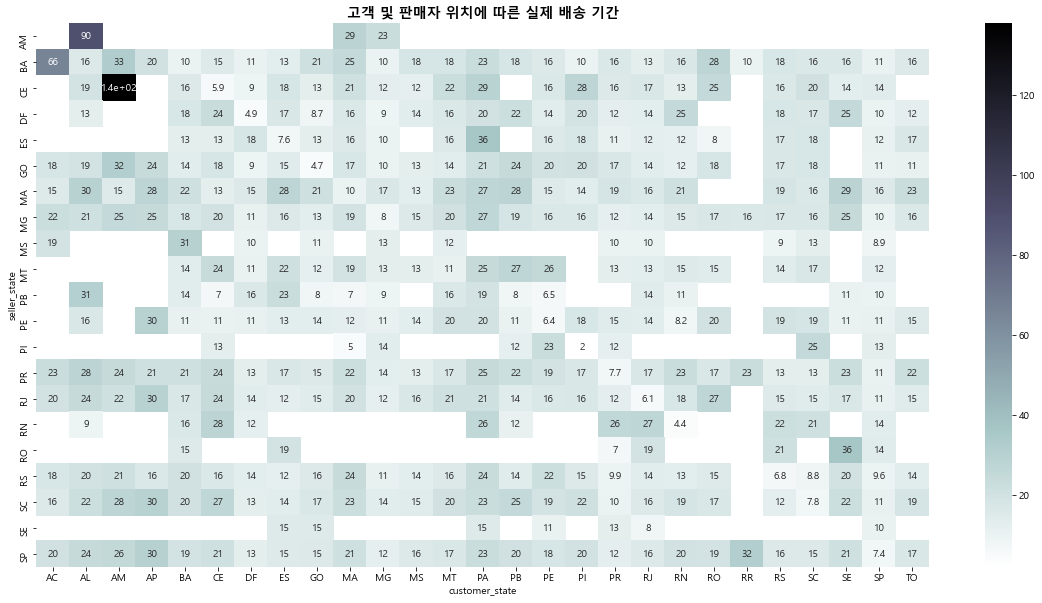

In [41]:
pivottable = pd.pivot_table(data = df_delivery,index = "seller_state", columns = "customer_state", values = "diffdays_order_delivery", aggfunc = "mean")

fig,ax = plt.subplots(figsize = (20,10))
sns.heatmap(pivottable,annot = True, cmap = plt.cm.bone_r)
ax.set_title("고객 및 판매자 위치에 따른 실제 배송 기간",size = 14, fontweight = "bold")
plt.show()

In [42]:
df_delivery["order_estimated"] = (df_delivery.order_estimated_delivery_date - df_delivery.order_purchase_timestamp).dt.days

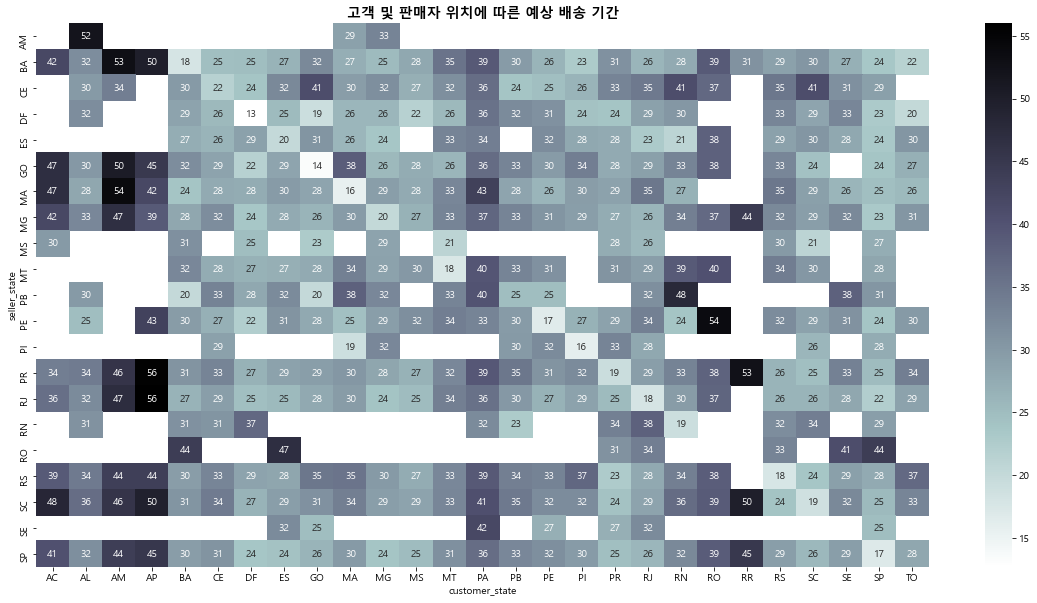

In [43]:
pivottable = pd.pivot_table(data = df_delivery,index = "seller_state", columns = "customer_state", values = "order_estimated", aggfunc = "mean")

fig,ax = plt.subplots(figsize = (20,10))
sns.heatmap(pivottable,annot = True, cmap = plt.cm.bone_r)
ax.set_title("고객 및 판매자 위치에 따른 예상 배송 기간",size = 14, fontweight = "bold")
plt.show()

## 리뷰 스코어

### 스코어 비율

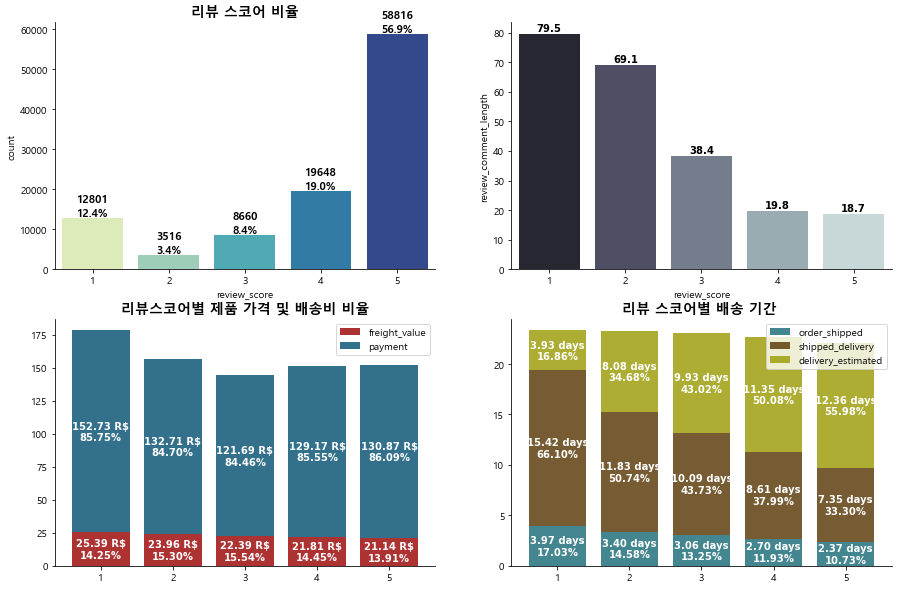

In [44]:
fig = plt.figure(figsize = (15,10))
gs = GridSpec(2,2, figure = fig)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])

#리뷰스코어 비율
sns.countplot(data = df, x = "review_score", ax = ax1, palette="YlGnBu")
ax1.set_title("리뷰 스코어 비율",size = 14, fontweight = "bold")
for i,num in enumerate(df.review_score.value_counts().sort_index().tolist()):
    ax1.annotate(s = f"{num}\n{num/df.shape[0]*100:.1f}%",
                xy = [i, num+3000], va = "center", ha = 'center', size = 11, fontweight = "bold")
    
#리뷰스코어별 코멘트 길이
sns.barplot(data = df, x = "review_score", y="review_comment_length", ax=ax2, ci = None, palette = "bone")    
score_ReviewLength = df.groupby("review_score").review_comment_length.mean().round(1).to_frame()
for i in score_ReviewLength.index:
    ax2.annotate(s = f"{score_ReviewLength.loc[i,'review_comment_length']}",
                 xy = [i-1,score_ReviewLength.loc[i,"review_comment_length"]+2], va = "center", ha ="center",
                 fontweight = "bold", fontfamily = "Sans Serif")
    
#리뷰스코어별 제품 가격 및 배송비 비율
df_temp = df.copy()
df_temp["payment"] = df_temp.total_payment - df_temp.freight_value
df_plot = df_temp.groupby("review_score").agg({"payment":"mean","freight_value":"mean"})
df_plot["total_payment"] = df_plot.payment + df_plot.freight_value

ax3.bar(x = df_plot.index, height = df_plot.freight_value, color = "#990000", alpha = 0.8, label = "freight_value")
ax3.bar(x = df_plot.index, height = df_plot.payment, color = "#004c70", alpha = 0.8, label = "payment",bottom = df_plot.freight_value)
for i in df_plot.index:
    ax3.annotate(s = f"{df_plot.loc[i,'payment']:.2f} R$\n{df_plot.loc[i,'payment']/df_plot.loc[i,'total_payment']*100:.2f}%",
                 xy = [i, df_plot.loc[i, 'payment']/2 + df_plot.loc[i, 'freight_value']],
                 va = "center", ha = "center", color = 'w', fontweight = 'bold', fontfamily = "Sans Serif")

for i in df_plot.index:
    ax3.annotate(s = f"{df_plot.loc[i,'freight_value']:.2f} R$\n{df_plot.loc[i,'freight_value']/df_plot.loc[i,'total_payment']*100:.2f}%",
                 xy = [i, df_plot.loc[i, 'freight_value']/2],
                 va = "center", ha = "center", color = 'w', fontweight = 'bold', fontfamily = "Sans Serif")
ax3.set_title("리뷰스코어별 제품 가격 및 배송비 비율",size = 14, fontweight = "bold")
ax3.legend(loc='upper right')

#리뷰스코어별 평균 구매-상품적재 기간, 상품적재-배송완료 기간, 배송완료-예정배송 차이
df_delivery_groupby = df_delivery.copy()
df_delivery_groupby["order_shipped"] = (df_delivery_groupby.order_delivered_carrier_date - df_delivery_groupby.order_purchase_timestamp).dt.days
df_delivery_groupby["shipped_delivery"] = (df_delivery_groupby.order_delivered_customer_date - df_delivery_groupby.order_delivered_carrier_date).dt.days
df_delivery_groupby["delivery_estimated"] =  (df_delivery_groupby.order_estimated_delivery_date - df_delivery_groupby.order_delivered_customer_date).dt.days

df_delivery_groupby = df_delivery_groupby.groupby("review_score").\
agg({"order_shipped":"mean","shipped_delivery":"mean", "delivery_estimated":"mean"})
df_delivery_groupby["tot"] = df_delivery_groupby.sum(axis=1)

ax4.bar(x = df_delivery_groupby.index, height = df_delivery_groupby.order_shipped,
        color = "#156875", alpha = 0.8, label = "order_shipped")
ax4.bar(x = df_delivery_groupby.index, height = df_delivery_groupby.shipped_delivery,
        color = "#553300", alpha = 0.8, label = "shipped_delivery", bottom = df_delivery_groupby.order_shipped)
ax4.bar(x = df_delivery_groupby.index, height = df_delivery_groupby.delivery_estimated,
        color = "#999900", alpha = 0.8, label = "delivery_estimated", bottom = df_delivery_groupby.shipped_delivery + df_delivery_groupby.order_shipped)

for i in df_delivery_groupby.index:
    ax4.annotate(s = f"{df_delivery_groupby.loc[i,'order_shipped']:.2f} days\n{df_delivery_groupby.loc[i,'order_shipped']/df_delivery_groupby.loc[i,'tot']*100:.2f}%",
                 xy = [i, df_delivery_groupby.loc[i, 'order_shipped']/2],
                 va = "center", ha = "center", color = 'w', fontweight = 'bold', fontfamily = "Sans Serif")

for i in df_delivery_groupby.index:
    ax4.annotate(s = f"{df_delivery_groupby.loc[i,'shipped_delivery']:.2f} days\n{df_delivery_groupby.loc[i,'shipped_delivery']/df_delivery_groupby.loc[i,'tot']*100:.2f}%",
                 xy = [i, df_delivery_groupby.loc[i, 'shipped_delivery']/2 + df_delivery_groupby.loc[i, 'order_shipped']],
                 va = "center", ha = "center", color = 'w', fontweight = 'bold', fontfamily = "Sans Serif")

for i in df_delivery_groupby.index:
    ax4.annotate(s = f"{df_delivery_groupby.loc[i,'delivery_estimated']:.2f} days\n{df_delivery_groupby.loc[i,'delivery_estimated']/df_delivery_groupby.loc[i,'tot']*100:.2f}%",
                 xy = [i, df_delivery_groupby.loc[i, 'delivery_estimated']/2 + df_delivery_groupby.loc[i, 'shipped_delivery'] + df_delivery_groupby.loc[i, 'order_shipped']],
                 va = "center", ha = "center", color = 'w', fontweight = 'bold', fontfamily = "Sans Serif")    

ax4.set_title("리뷰 스코어별 배송 기간 ",size = 14, fontweight = "bold")    
ax4.legend(loc='upper right')
sns.despine()

## order_id별 상품 주문 개수

<AxesSubplot:xlabel='item_nb', ylabel='review_score'>

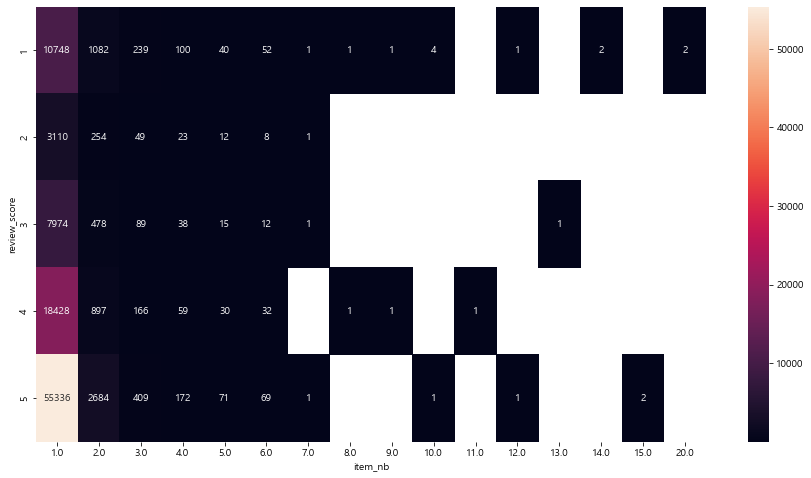

In [45]:
pv_table = df.groupby(["review_score","item_nb"]).order_id.count().unstack()

plt.figure(figsize = (15,8))
sns.heatmap(pv_table, annot = True, fmt = '.5g')

### review_comment 워드클라우드

#### review datatset 기준 comment가 있는 관측치 개수

In [46]:
olist_order_reviews_temp = olist_order_reviews.copy()
df_comments = olist_order_reviews_temp[["review_score","review_comment_msg_en"]]
df_comments = df_comments.dropna(subset = ["review_comment_msg_en"], axis = 0)
df_comments = df_comments.reset_index(drop = True)
print(f"전체 Dataset shape : {olist_order_reviews.shape}")
print(f"comment가 모두 있는 Dataset shape : {df_comments.shape}")
df_comments.columns = ["score","comment_eng"]


전체 Dataset shape : (100000, 9)
comment가 모두 있는 Dataset shape : (41725, 2)


#### 토큰화

In [47]:
def tokenize_text(text, lang = 'english'):
    """
    text를 문장 및 단어 토큰화하여 반환
    text : string type
    language : 입력한 text type
    """
    sentences = sent_tokenize(text = text,language= lang)
    word_tokens = [word_tokenize(text = sentence, language= lang) for sentence in sentences]
    return word_tokens

#### 불용어 처리

In [48]:
stopwords = nltk.corpus.stopwords.words("english")

def remove_stopwords(word_tokens):
    """
    and, he, 등과 같은 불용어 제거
    """
    word_tokens = word_tokens
    all_token = []

    #빈 리스트 생성
    filtered_words = []

    #개별 문장별로 토큰화된 문장 list에 대해 불용어 제거
    for word in word_tokens:

        #소문자로 변환
        word = word.lower()

        #토큰화된 개별 단어가 불용어에 포함되지 않으면 word_tokens에 추가
        if word not in stopwords:
            filtered_words.append(word)
    all_token.append(filtered_words)
    return all_token[0]

#### 함수 적용하여 comment 전처리

In [49]:
porter = nltk.stem.PorterStemmer()
lancaster = nltk.stem.LancasterStemmer()
snowball = nltk.stem.SnowballStemmer("english")
lemma = nltk.stem.WordNetLemmatizer()

df_comments["text_tokens"] = np.nan
df_comments["stem_porter"] = np.nan
df_comments["stem_lancaster"] = np.nan
df_comments["stem_snowball"] = np.nan
df_comments["lemma"] = np.nan

for i,comment in enumerate(df_comments.comment_eng):
    if i%1000==0:
        print(f"[ {(i+1)/len(df_comments.comment_eng)*100:.0f}% ] {i} 번째 index 진행 중")
    elif (i+1)==len(df_comments.comment_eng):
        print("end")
    
    #토큰화
    sentences = tokenize_text(comment, lang = 'english')
    
    #불용어 처리
    #stemming & lemmatization 결과를 저장할 리스트 객체 생성
    words_token = []
    porter_result = []
    lancaster_result = []
    snowball_result = []
    lemma_result = []
    for sentence in sentences:
        #불용어 처리
        sentence = remove_stopwords(sentence)
        
        for word in sentence:
            #단어 중 2글자 이상의 알파벳으로 된 단어만 추출
            if (re.search(r'[a-zA-Z]',word)!=None) & (len(word)>2):
                word = re.sub(r'[^A-Za-z]', '', word).lower()# 문자열 중 특수문자 제거
                words_token.append(word)
                porter_result.append(porter.stem(word))
                lancaster_result.append(lancaster.stem(word))
                snowball_result.append(snowball.stem(word))
                lemma_result.append(lemma.lemmatize(word))
            
    #dataframe에 리스트 객체 저장
    df_comments["text_tokens"][i] = words_token
    df_comments["stem_porter"][i] = porter_result
    df_comments["stem_lancaster"][i] = lancaster_result
    df_comments["stem_snowball"][i] = snowball_result
    df_comments["lemma"][i] = lemma_result

[ 0% ] 0 번째 index 진행 중
[ 2% ] 1000 번째 index 진행 중
[ 5% ] 2000 번째 index 진행 중
[ 7% ] 3000 번째 index 진행 중
[ 10% ] 4000 번째 index 진행 중
[ 12% ] 5000 번째 index 진행 중
[ 14% ] 6000 번째 index 진행 중
[ 17% ] 7000 번째 index 진행 중
[ 19% ] 8000 번째 index 진행 중
[ 22% ] 9000 번째 index 진행 중
[ 24% ] 10000 번째 index 진행 중
[ 26% ] 11000 번째 index 진행 중
[ 29% ] 12000 번째 index 진행 중
[ 31% ] 13000 번째 index 진행 중
[ 34% ] 14000 번째 index 진행 중
[ 36% ] 15000 번째 index 진행 중
[ 38% ] 16000 번째 index 진행 중
[ 41% ] 17000 번째 index 진행 중
[ 43% ] 18000 번째 index 진행 중
[ 46% ] 19000 번째 index 진행 중
[ 48% ] 20000 번째 index 진행 중
[ 50% ] 21000 번째 index 진행 중
[ 53% ] 22000 번째 index 진행 중
[ 55% ] 23000 번째 index 진행 중
[ 58% ] 24000 번째 index 진행 중
[ 60% ] 25000 번째 index 진행 중
[ 62% ] 26000 번째 index 진행 중
[ 65% ] 27000 번째 index 진행 중
[ 67% ] 28000 번째 index 진행 중
[ 70% ] 29000 번째 index 진행 중
[ 72% ] 30000 번째 index 진행 중
[ 74% ] 31000 번째 index 진행 중
[ 77% ] 32000 번째 index 진행 중
[ 79% ] 33000 번째 index 진행 중
[ 81% ] 34000 번째 index 진행 중
[ 84% ] 35000 번째 index 진행 중
[ 86% ] 3

#### 워드클라우드

In [50]:
#socre별 데이터셋 생성
df_comments_1 = df_comments[df_comments.score==1].reset_index(drop=True)
df_comments_2 = df_comments[df_comments.score==2].reset_index(drop=True)
df_comments_3 = df_comments[df_comments.score==3].reset_index(drop=True)
df_comments_4 = df_comments[df_comments.score==4].reset_index(drop=True)
df_comments_5 = df_comments[df_comments.score==5].reset_index(drop=True)

In [51]:
#socre별 단어 정리 함수 생성
def wordcloud_by_dict_data(data, k = 0,n=50):
    """
    dict type 데이터로 word cloud 생성
    data = dataframe
    k = 0: 원본 단어 토큰(default)  
        1: portstemmer 추출  
        2: lancasterstmmer 추출  
        3: snowballstemmer추출  
        4: lemmatization  
        
    n = 생성할 words 개수
    """
    words = ['text_tokens','stem_porter','stem_lancaster','stem_snowball','lemma']
    
    #dataframe에서 각 행마다 문장별 리스트 형태로 되어있으므로 단어별로 대체
    data_word = [word for sentence in data[words[k]] for word in sentence]
    
    #단어별 개수 세기
    word_count_sorted = Counter(data_word)
    
    #카운트 횟수가 상위 n개인 단어 추출
    words = word_count_sorted.most_common(n)
    
    #워드클라우드
    tmp = WordCloud(font_path='c:/windows/fonts/Gothic.ttf',
    #                       width = 1000,
    #                       height = 1000,
                          max_words = n,
                          max_font_size = 300,
                          background_color='white').generate_from_frequencies(dict(words))
    return tmp

Text(0.5, 1.0, 'score_5')

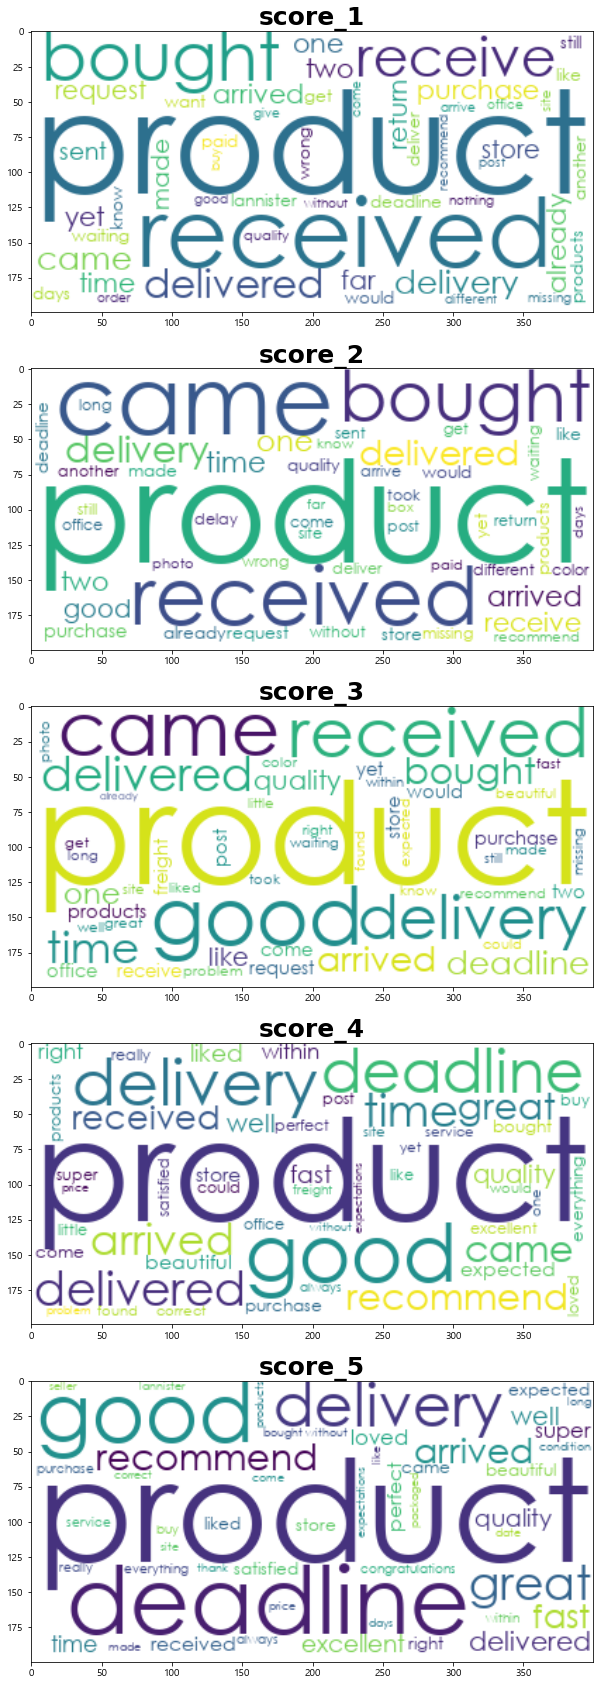

In [52]:
#어떤 텍스트로 진행할 지 선택
# 0 : 원본 단어 토큰, 1: portstemmer 추출, 2:lancasterstmmer 추출, 3. snowballstemmer추출, 4. lemmatization
# 0으로 진행, 어간 or 표제어로 대체하려고 했으나, 오히려 단어를 잘못 변형하는 문제가 있으므로 단어 토큰화 한 결과로 진행# 0으로 진행, 어간 or 표제어로 대체하려고 했으나, 오히려 단어를 잘못 변형하는 문제가 있으므로 단어 토큰화 한 결과로 진행
k = 0
score_1_word_cloud = wordcloud_by_dict_data(df_comments_1,k = k, n = 50)
score_2_word_cloud = wordcloud_by_dict_data(df_comments_2,k = k, n = 50)
score_3_word_cloud = wordcloud_by_dict_data(df_comments_3,k = k, n = 50)
score_4_word_cloud = wordcloud_by_dict_data(df_comments_4,k = k, n = 50)
score_5_word_cloud = wordcloud_by_dict_data(df_comments_5,k = k, n = 50)

fig,ax = plt.subplots(5,1,figsize=(20, 30))
ax[0].imshow(score_1_word_cloud, interpolation="bilinear")
ax[1].imshow(score_2_word_cloud, interpolation="bilinear")
ax[2].imshow(score_3_word_cloud, interpolation="bilinear")
ax[3].imshow(score_4_word_cloud, interpolation="bilinear")
ax[4].imshow(score_5_word_cloud, interpolation="bilinear")

ax[0].set_title("score_1", fontsize = 25, fontweight = "bold", fontfamily = "Sans Serif")
ax[1].set_title("score_2", fontsize = 25, fontweight = "bold", fontfamily = "Sans Serif")
ax[2].set_title("score_3", fontsize = 25, fontweight = "bold", fontfamily = "Sans Serif")
ax[3].set_title("score_4", fontsize = 25, fontweight = "bold", fontfamily = "Sans Serif")
ax[4].set_title("score_5", fontsize = 25, fontweight = "bold", fontfamily = "Sans Serif")

### estimated - delivered별

Text(0.5, 1.0, '배송 완료 예정일 대비 실제 완료 일수와 review_score violin plot')

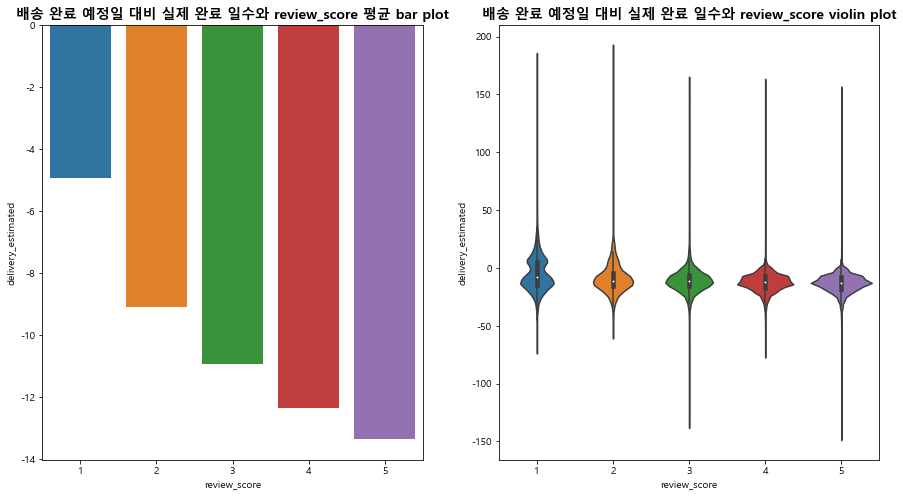

In [53]:
fig,ax = plt.subplots(1,2, figsize = (15,8))

df_delivery_groupby = df_delivery.copy()
df_delivery_groupby["delivery_estimated"] =  (df_delivery_groupby.order_delivered_customer_date - df_delivery_groupby.order_estimated_delivery_date).dt.days


sns.barplot(x = df_delivery_groupby.review_score, y = df_delivery_groupby.delivery_estimated, ci = False, ax=ax[0])
ax[0].set_title("배송 완료 예정일 대비 실제 완료 일수와 review_score 평균 bar plot", size = 14, fontweight = "bold")

sns.violinplot(x = df_delivery_groupby.review_score, y = df_delivery_groupby.delivery_estimated, ax=ax[1])
ax[1].set_title("배송 완료 예정일 대비 실제 완료 일수와 review_score violin plot", size = 14, fontweight = "bold")

### seller or cumster state별

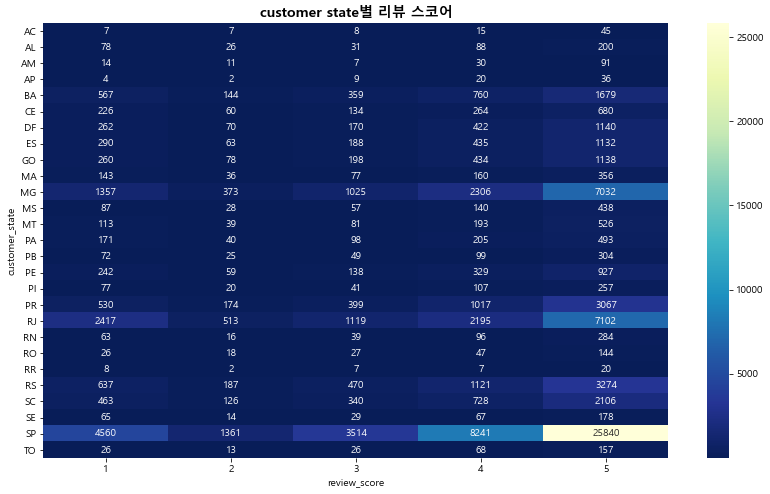

In [54]:
tmp = df.groupby(["review_score","customer_state"]).order_id.count().unstack(0)
plt.figure(figsize = (14,8))
g = sns.heatmap(tmp,annot = True, fmt = '.5g', cmap = "YlGnBu_r")
g.set_title("customer state별 리뷰 스코어", size = 14, fontweight = "bold")
plt.show()

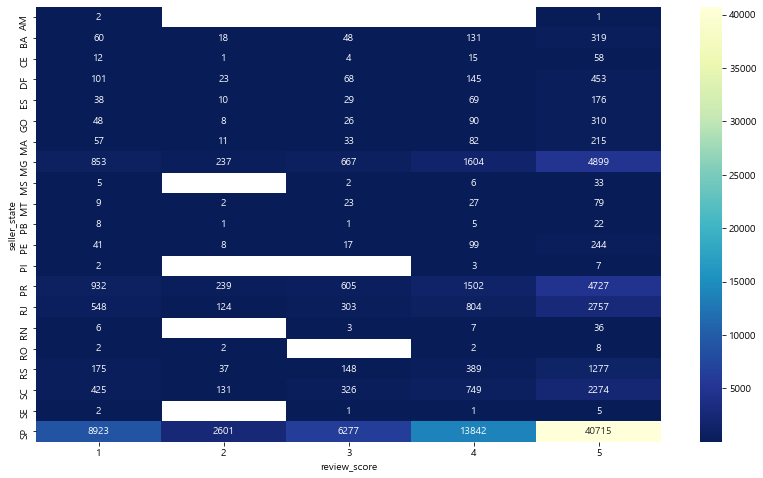

In [55]:
tmp = df.groupby(["review_score","seller_state"]).order_id.count().unstack(0).round()
plt.figure(figsize = (14,8))
sns.heatmap(tmp,annot = True, fmt = '.5g', cmap = "YlGnBu_r")
g.set_title("seller state별 리뷰 스코어", size = 14, fontweight = "bold")
plt.show()

### 상위 카테고리별

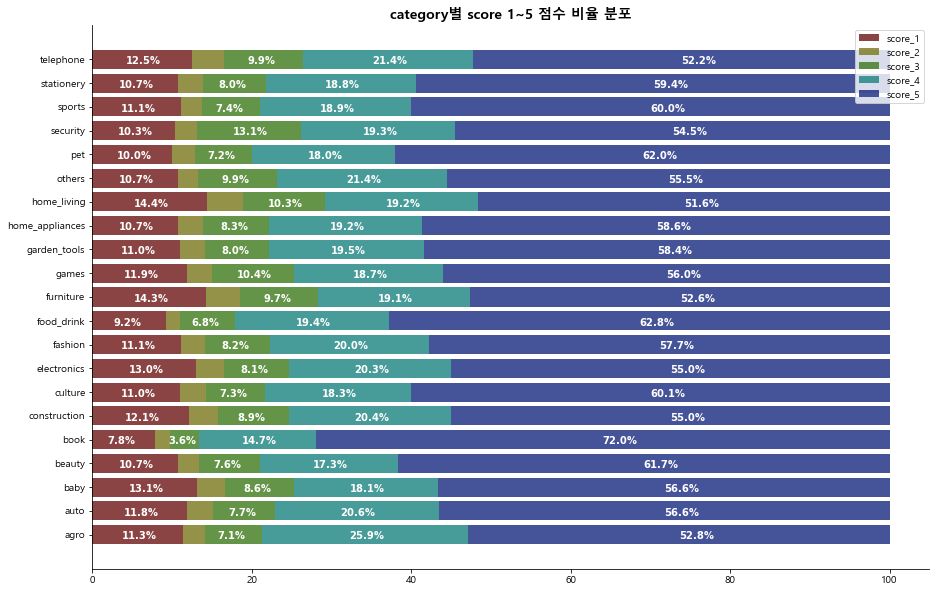

In [56]:
cate_score = df.groupby(["product_category_upper","review_score"]).order_id.count().reset_index()
cate_score_nb = df.groupby(["product_category_upper"]).review_score.count().reset_index()
cate_score = cate_score.merge(cate_score_nb, on = "product_category_upper")
cate_score["score_ratio"] = (cate_score.order_id / cate_score.review_score_y*100).round(2)

fig,ax = plt.subplots(figsize = (15,10))
ax.barh(y = cate_score.loc[cate_score.review_score_x==1,"product_category_upper"],
        width = cate_score.loc[cate_score.review_score_x==1,"score_ratio"], color = "#6e1515", alpha = 0.8, label = "score_1")

left1 = cate_score.loc[cate_score.review_score_x==1,"score_ratio"].tolist()
ax.barh(y = cate_score.loc[cate_score.review_score_x==2,"product_category_upper"],
        width = cate_score.loc[cate_score.review_score_x==2,"score_ratio"], color = "#7a771a", alpha = 0.8, label = "score_2",
        left = left1)

left2 = (cate_score.loc[cate_score.review_score_x==1,"score_ratio"].tolist()\
        +cate_score.loc[cate_score.review_score_x==2,"score_ratio"]).tolist()
ax.barh(y = cate_score.loc[cate_score.review_score_x==3,"product_category_upper"],
        width = cate_score.loc[cate_score.review_score_x==3,"score_ratio"], color = "#3d7a1a", alpha = 0.8, label = "score_3",
        left = left2)

left3 = ((cate_score.loc[cate_score.review_score_x==1,"score_ratio"].tolist()\
        +cate_score.loc[cate_score.review_score_x==2,"score_ratio"]).tolist()\
        +cate_score.loc[cate_score.review_score_x==3,"score_ratio"]).tolist()
ax.barh(y = cate_score.loc[cate_score.review_score_x==4,"product_category_upper"],
        width = cate_score.loc[cate_score.review_score_x==4,"score_ratio"], color = "#198280", alpha = 0.8, label = "score_4",
        left = left3)

left4 = (((cate_score.loc[cate_score.review_score_x==1,"score_ratio"].tolist()\
        +cate_score.loc[cate_score.review_score_x==2,"score_ratio"]).tolist()\
        +cate_score.loc[cate_score.review_score_x==3,"score_ratio"]).tolist()\
        +cate_score.loc[cate_score.review_score_x==4,"score_ratio"]).tolist()
ax.barh(y = cate_score.loc[cate_score.review_score_x==5,"product_category_upper"],
        width = cate_score.loc[cate_score.review_score_x==5,"score_ratio"], color = "#172880", alpha = 0.8, label = "score_5",
        left = left4)
ax.legend(loc = "upper right")

for i, num in enumerate(cate_score[cate_score.review_score_x==1].score_ratio):
    ax.annotate(s = f"{num:.1f}%",
                xy = [num/2-2,i-0.2],color = 'w', fontweight = "bold", fontfamily = "Sans Serif")
    
for i, num in enumerate(cate_score[cate_score.review_score_x==3].score_ratio):
    ax.annotate(s = f"{num:.1f}%",
                xy = [left2[i]+num/2-2,i-0.2],color = 'w', fontweight = "bold", fontfamily = "Sans Serif")

for i, num in enumerate(cate_score[cate_score.review_score_x==4].score_ratio):
    ax.annotate(s = f"{num:.1f}%",
                xy = [left3[i]+num/2-2,i-0.2],color = 'w', fontweight = "bold", fontfamily = "Sans Serif")
    
for i, num in enumerate(cate_score[cate_score.review_score_x==5].score_ratio):
    ax.annotate(s = f"{num:.1f}%",
                xy = [left4[i]+num/2,i-0.2],color = 'w', fontweight = "bold", fontfamily = "Sans Serif")
    
sns.despine()
ax.set_title("category별 score 1~5 점수 비율 분포", size = 14, fontweight = "bold")
plt.show()

### product_description_length or product_photos_qty

Text(0.5, 1.0, '제품 관련 이미지 개수와 review_score')

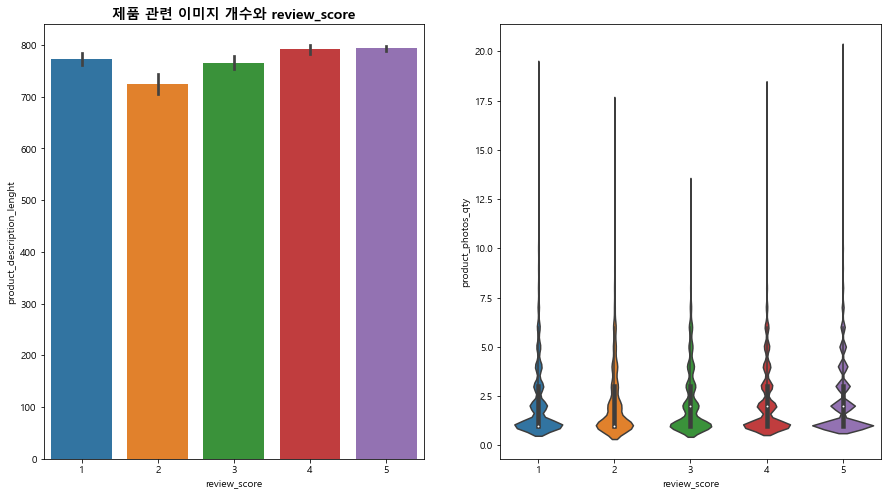

In [57]:
fig,ax = plt.subplots(1,2, figsize = (15,8))

sns.barplot(x = df.review_score, y = df.product_description_lenght, ax = ax[0])
ax[0].set_title("제품 설명 길이와 review_score", size = 14, fontweight = "bold")
sns.violinplot(x = df.review_score, y = df.product_photos_qty, ax = ax[1])
ax[0].set_title("제품 관련 이미지 개수와 review_score", size = 14, fontweight = "bold")

# 2차 전처리

## 이상치 처리

### order_id별 review 개수가 2개 이상인 경우 제거
**특정 order_id에서 review 개수가 2개 이상인데, 이 경우 단순히 점수를 올리기 위해서 발생한 경우도 있고,
실제로 판매자가 특정 상황이 발생하여 대처 전후에 대해 review를 한 경우가 있으나,
모든 경우를 고려하기가 불가하여 해당 order_id 제거**

In [58]:
OrderId_ReviewId = olist_order_reviews.groupby("order_id").review_id.agg("nunique").reset_index()
order_id_list = OrderId_ReviewId[OrderId_ReviewId.review_id>1].order_id.tolist()
df = df[~df.order_id.isin(order_id_list)]

### order_id별 seller가 2명 이상인 경우 제거
**각 order_id별로 review_score가 정해지는데, seller가 두명 이상인 경우 사항으로 점수가 기입됐는지 확인이 불가**

In [59]:
OrderID_SellerID = df.groupby("order_id").seller_id.nunique().reset_index()
order_id_list = OrderID_SellerID[OrderID_SellerID.seller_id>1].order_id.tolist()
df = df[~df.order_id.isin(order_id_list)]

### review_id별 order_id가 2개 이상인 경우 제거

In [60]:
review_id_list = df.groupby("review_id").order_id.nunique().sort_values().to_frame()
error_review_list = review_id_list[review_id_list.order_id > 1].index.tolist()
df = df[~df.review_id.isin(error_review_list)].copy()

### 구매 시점이 결제 승인, 상품 준비, 배송완료일, 배송완료 예정일 보다 늦은 판매건 제거

In [61]:
print(f" order_purchase_timestamp > order_approved_at : {len(df[df.order_purchase_timestamp > df.order_approved_at])}")
print(f" order_purchase_timestamp > order_delivered_customer_date : {len(df[df.order_purchase_timestamp > df.order_delivered_customer_date])}")
print(f" order_purchase_timestamp > order_delivered_carrier_date : {len(df[df.order_purchase_timestamp > df.order_delivered_carrier_date])}")
print(f" order_purchase_timestamp > order_estimated_delivery_date : {len(df[df.order_purchase_timestamp > df.order_estimated_delivery_date])}")

 order_purchase_timestamp > order_approved_at : 0
 order_purchase_timestamp > order_delivered_customer_date : 0
 order_purchase_timestamp > order_delivered_carrier_date : 164
 order_purchase_timestamp > order_estimated_delivery_date : 0


In [62]:
df = df[(df.order_purchase_timestamp <= df.order_delivered_carrier_date)|(df.order_delivered_carrier_date.isnull())]

## 결측치 처리

In [63]:
null_sum = df.isnull().sum().sort_values(ascending=False).to_frame().rename(columns = {0 : "null(nb)"})
null_mean = (df.isnull().mean()*100).sort_values(ascending=False).round(2).to_frame().rename(columns = {0 : "null(%)"})
print(df.shape)
null_list = pd.merge(null_sum,null_mean,left_index = True, right_index = True, how = "outer")
null_list[null_list["null(nb)"]>0].T

(98648, 51)


,review_comment_title,review_comment_msg_en,review_comment_message,order_delivered_customer_date,product_category_name_english,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_category_upper,order_delivered_carrier_date,geolocation_lng_x,seller_state,seller_zip_code_prefix,geolocation_lat_x,product_width_cm,product_length_cm,product_weight_g,product_height_cm,freight_value_rate,freight_value,seller_id,item_nb,product_id,total_payment,customer_zip_code_prefix,geolocation_lat_y,customer_state,geolocation_lng_y,order_approved_at
null(nb),87099.00,57614.0,57587.00,2834.00,2101.00,2101.00,2101.00,2101.00,2101.00,2101.00,1669.00,907.00,907.00,907.00,907.00,710.00,710.00,710.00,710.00,694.0,694.0,694.0,694.0,694.0,694.0,273.00,273.00,273.00,273.00,99.0
null(%),88.29,58.4,58.38,2.87,2.13,2.13,2.13,2.13,2.13,2.13,1.69,0.92,0.92,0.92,0.92,0.72,0.72,0.72,0.72,0.7,0.7,0.7,0.7,0.7,0.7,0.28,0.28,0.28,0.28,0.1


### 불필요한 컬럼 삭제

In [64]:
# column_list = ["product_id","product_category_name",'product_weight_g','product_length_cm',
#                'product_height_cm', 'product_width_cm','product_height_cm', 'product_width_cm',
#                'product_category_name_english','seller_zip_code_prefix','geolocation_lat_x','geolocation_lng_x',
#                'customer_id','order_approved_at','customer_zip_code_prefix','geolocation_lat_y',
#                'geolocation_lng_y', 'payment_value','review_id','review_comment_title',
#                'review_comment_message','review_creation_date', 'review_answer_timestamp','review_comment_msg_en']

column_list = ["product_category_name",'product_weight_g','product_length_cm',
               'product_height_cm', 'product_width_cm','product_height_cm', 'product_width_cm',
               'seller_zip_code_prefix','geolocation_lat_x','geolocation_lng_x',
               'customer_id','order_approved_at','customer_zip_code_prefix','geolocation_lat_y',
               'geolocation_lng_y', 'payment_value','review_id','review_comment_title',
               'review_answer_timestamp','review_comment_msg_en']

df = df.drop(columns = column_list,axis = 1)
df.shape

(98648, 33)

### product_category_upper이 결측치인 관측치 제거

In [65]:
df_temp = df[df.product_category_upper.notnull()==True].copy()

null_sum = df_temp.isnull().sum().sort_values(ascending=False).to_frame().rename(columns = {0 : "null(nb)"})
null_mean = (df_temp.isnull().mean()*100).sort_values(ascending=False).round(2).to_frame().rename(columns = {0 : "null(%)"})
print(df_temp.shape)
null_list = pd.merge(null_sum,null_mean,left_index = True, right_index = True, how = "outer")
null_list[null_list["null(nb)"]>0].T

(96547, 33)


,review_comment_message,order_delivered_customer_date,order_delivered_carrier_date,customer_state,seller_state
null(nb),56579.0,2083.00,943.00,263.00,212.00
null(%),58.6,2.16,0.98,0.27,0.22


### order_delivered_customer_date 결측치 확인
***
- delivered인데 결측치가 있는 관측치는 제거

(98648, 33)
total : 2083


shipped       1068
canceled       428
invoiced       289
processing     288
delivered        8
approved         2
Name: order_status, dtype: int64

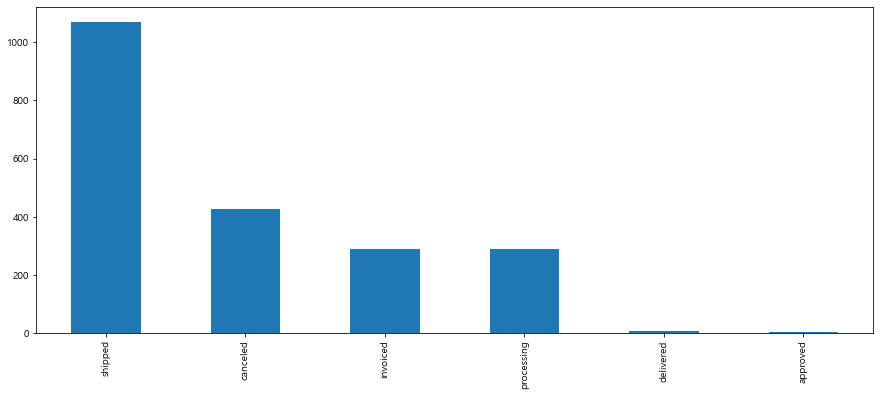

In [66]:
print(df.shape)
df_temp[df_temp.order_delivered_customer_date.isnull()==True].order_status.value_counts().plot.bar(figsize = (15,6))

print(f"total : {df_temp[df_temp.order_delivered_customer_date.isnull()==True].order_status.value_counts().sum()}")
df_temp[df_temp.order_delivered_customer_date.isnull()==True].order_status.value_counts()

**order_status == delivered인데  
(1)order_delivered_carrier_date  
(2)order_delivered_customer_date  
가 없는 관측치 제거**

In [67]:
df_temp = df_temp[(df_temp.order_status!="delivered") | (df_temp.order_delivered_carrier_date.notnull()==True)]
df_temp = df_temp[(df.order_status!="delivered") | (df.order_delivered_customer_date.notnull()==True)]

print(df.shape)
df_temp.isnull().sum().sort_values(ascending = False)

(98648, 33)


review_comment_message           56575
order_delivered_customer_date     2075
order_delivered_carrier_date       941
customer_state                     263
seller_state                       212
week                                 0
month_name                           0
month                                0
year                                 0
customer_unique_id                   0
order_purchase_time                  0
review_comment_length                0
review_creation_date                 0
day                                  0
review_score                         0
dayofweek                            0
year_month                           0
order_id                             0
order_estimated_delivery_date        0
product_id                           0
order_purchase_timestamp             0
order_status                         0
product_category_upper               0
product_category_name_english        0
product_photos_qty                   0
product_description_lengh

### state 결측치 처리
***
- state가 없는 고객 및 판매자 관측치는 제거

In [68]:
df_temp = df_temp[(df_temp.seller_state.notnull()) & (df_temp.customer_state.notnull())]
# df_temp = df_temp[df_temp.seller_zip_code_prefix.notnull()]
print(df_temp.shape)
df_temp.isnull().sum().sort_values(ascending = False)

(96064, 33)


review_comment_message           56289
order_delivered_customer_date     2063
order_delivered_carrier_date       935
order_purchase_time                  0
customer_state                       0
review_score                         0
review_creation_date                 0
review_comment_length                0
year_month                           0
order_estimated_delivery_date        0
year                                 0
month                                0
month_name                           0
week                                 0
day                                  0
dayofweek                            0
customer_unique_id                   0
order_id                             0
product_id                           0
order_purchase_timestamp             0
order_status                         0
seller_state                         0
product_category_upper               0
product_category_name_english        0
product_photos_qty                   0
product_description_lengh

### payment_value 결측치 확인 => total_payment 대체
***
- payment_value 값 자체가 오계산된 것을 확인하여 total_payment 대체

In [69]:
tmp_items = olist_order_items.groupby("order_id").total_payment.sum().reset_index()

tmp = pd.merge(olist_order_payments,tmp_items,on="order_id")
tmp = tmp.groupby("order_id").agg({"payment_value" : "sum", "total_payment" : "mean"}).reset_index()
tmp[abs(tmp.payment_value-tmp.total_payment)>0.1]

,order_id,payment_value,total_payment
165,00789ce015e7e5791c7914f32bb4fad4,190.81,168.83
525,016726239765c18f66826453f39c64e3,265.77,235.13
724,01e51b7c3025655646143d09b911e1d7,35.02,33.10
965,028aa7c930356788f861ed1b7f984819,62.94,57.53
1123,02f4dd90ba0feb8ec394cac05862d2b5,141.65,130.96
...,...,...,...
96560,fa87437f971fce498b2184cd2401e23e,66.93,63.27
96713,faf132fb35b3b3b533a67efbd6e7c02d,130.01,115.02
97100,fbf352b18a26c6a86a53cca922facd25,160.80,151.54
97605,fd33085945f15975375cd8ec85440511,212.82,234.62


In [70]:
olist_order_items[olist_order_items.order_id=="00789ce015e7e5791c7914f32bb4fad4"]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,total_payment
185,00789ce015e7e5791c7914f32bb4fad4,1,f9d774a1820f792952eea079a40a7c6b,2709af9587499e95e803a6498a5a56e9,2017-07-04 23:43:34,154.0,14.83,168.83


# Feature Eng

## 컬럼 생성

### review_score 목표변수 컬럼 변경(1,2,3,4,5 => 1,0)
---
review_score가 1,2,3 일 경우 1 / 4,5일 경우 0

In [71]:
df_temp["review_score_binary"] = df_temp.apply(lambda x : 1 if x.review_score <= 3 else 0, axis = 1)

### 누적 review_score_10 비율 컬럼 생성

In [72]:
#누적 리뷰 스코어 데이터셋 생성
review_ratio_cummean = df_temp.groupby(['seller_id', 'review_creation_date'])\
                       .review_score_binary.agg({"sum","count"}).groupby(level=0).cumsum().reset_index()\
                       .rename(columns = {"count" : "score_cumcount", "sum" : "score_cumsum"})

review_ratio_cummean["review_score_binary_cummean"] = review_ratio_cummean.apply(lambda x : x.score_cumsum / x.score_cumcount, axis = 1)
review_ratio_cummean = review_ratio_cummean.drop(["score_cumcount","score_cumsum"],axis=1).copy()

#review comment가 등록된 첫 날과 마지막 날 확인
review_ratio_cummean["first_date"] = review_ratio_cummean.groupby("seller_id").review_creation_date.transform("min")
review_ratio_cummean["last_date"] = review_ratio_cummean.groupby("seller_id").review_creation_date.transform("max")

#seller & year_month expand.grid
seller_id_list = df_temp.seller_id.unique().tolist()
date_list = pd.date_range(start = "20160101" ,end = "20180831", freq = "D")
seller_dates_list = pd.DataFrame(np.array([(x,y) for x in seller_id_list for y in date_list]))\
                   .rename(columns = {0 : "seller_id", 1 : "dates"})
seller_dates_list["dates"]=seller_dates_list.dates.apply(pd.to_datetime)

#리뷰 코멘트가 달린 첫날 -1 & 마지막날 +1 사이의 데이터만 남기기
review_first_last_date = review_ratio_cummean[['seller_id','first_date','last_date']].drop_duplicates()
seller_dates_list = seller_dates_list.merge(review_first_last_date, on = "seller_id", how = "left")

cond = ((seller_dates_list.first_date - dt.timedelta(days = 1)) <= seller_dates_list.dates) &  \
       ((seller_dates_list.last_date + dt.timedelta(days = 1)) >= seller_dates_list.dates)
seller_dates_list_selected = seller_dates_list[cond].drop(["first_date",'last_date'],axis=1).copy()

# 모든 날의 cumsum값을 적용하고, 사이의 빈 값을 이전 값으로 대체
review_ratio_cummean = review_ratio_cummean.merge(seller_dates_list_selected,
                           left_on = ["seller_id","review_creation_date"],
                           right_on = ["seller_id","dates"],how = 'right')
review_ratio_cummean = review_ratio_cummean.fillna(method = "ffill").copy()

#cumsum값의 날짜를 하루씩 뒤로 미루기
review_ratio_cummean["review_score_binary_cummean"] = review_ratio_cummean.review_score_binary_cummean.shift(-1)

#첫날과 마지막날 사이의 날짜만 남기기
cond = (review_ratio_cummean.first_date <= review_ratio_cummean.dates) &  \
       (review_ratio_cummean.last_date >= review_ratio_cummean.dates)
review_ratio_cummean = review_ratio_cummean[cond].copy().drop(["review_creation_date","first_date","last_date"],axis = 1).copy()
review_ratio_cummean.head(2)

#주문 요청일 기준으로 리뷰 스코어 값 넣기
df_temp = df_temp.merge(review_ratio_cummean,
              left_on = ["seller_id","order_purchase_time"],
              right_on = ["seller_id","dates"],how = "left").drop("dates",axis = 1)

#Na 값 0으로 대체
df_temp["review_score_binary_cummean"] = df_temp.review_score_binary_cummean.fillna(0)
df_temp.head()

,order_id,product_id,seller_id,item_nb,total_payment,freight_value,freight_value_rate,product_name_lenght,product_description_lenght,product_photos_qty,product_category_name_english,product_category_upper,seller_state,order_status,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_state,review_score,review_comment_message,review_creation_date,review_comment_length,order_purchase_time,year_month,year,month,month_name,week,day,dayofweek,hour,review_score_binary,review_score_binary_cummean
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,1.0,72.19,13.29,18.41,58.0,598.0,4.0,cool_stuff,stationery,RJ,delivered,2017-09-13 08:59:02,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,871766c5855e863f6eccc05f988b23cb,RJ,5,"Perfeito, produto entregue antes do combinado.",2017-09-21,46,2017-09-13,2017-09-01,2017,9,Sep,2,13,Wed,8,0,0.182927
1,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,1.0,73.86,17.96,24.32,58.0,598.0,4.0,cool_stuff,stationery,RJ,delivered,2017-06-28 11:52:20,2017-07-05 12:00:33,2017-07-13 20:39:29,2017-07-26,0fb8e3eab2d3e79d92bb3fffbb97f188,GO,5,"lannister como sempre, entregou certinho e den...",2017-07-14,75,2017-06-28,2017-06-01,2017,6,Jun,2,28,Wed,11,0,0.241379
2,532ed5e14e24ae1f0d735b91524b98b9,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,1.0,83.23,18.33,22.02,58.0,598.0,4.0,cool_stuff,stationery,RJ,delivered,2018-05-18 10:25:53,2018-05-23 14:05:00,2018-06-04 18:34:26,2018-06-07,3419052c8c6b45daf79c1e426f9e9bcb,MG,4,carrinho muito bonito,2018-06-05,21,2018-05-18,2018-05-01,2018,5,May,4,18,Fri,10,0,0.237410
3,6f8c31653edb8c83e1a739408b5ff750,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,1.0,75.07,16.17,21.54,58.0,598.0,4.0,cool_stuff,stationery,RJ,delivered,2017-08-01 18:38:42,2017-08-02 19:07:36,2017-08-09 21:26:33,2017-08-25,e7c828d22c0682c1565252deefbe334d,PR,5,NaN,2017-08-10,0,2017-08-01,2017-08-01,2017,8,Aug,1,1,Tue,18,0,0.217391
4,7d19f4ef4d04461989632411b7e588b9,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,1.0,72.19,13.29,18.41,58.0,598.0,4.0,cool_stuff,stationery,RJ,delivered,2017-08-10 21:48:40,2017-08-11 19:43:07,2017-08-24 20:04:21,2017-09-01,0bb98ba72dcc08e95f9d8cc434e9a2cc,MG,5,NaN,2017-08-25,0,2017-08-10,2017-08-01,2017,8,Aug,3,10,Thu,21,0,0.204082


### 누적 review_comment 개수 컬럼 생성

In [73]:
#리뷰 코멘트 기입 여부 : 작성했으면 1 아니면 0인 컬럼 생성
df_temp["write_review_comment"] = df_temp.review_comment_length.apply(lambda x : 1 if x > 0 else 0)

In [74]:
#누적 리뷰 스코어 데이터셋 생성
review_comment_cumsum = df_temp.groupby(['seller_id', 'review_creation_date'])\
                       .write_review_comment.agg({"sum"}).groupby(level=0).cumsum().reset_index()\
                       .rename(columns = {"sum" : "comment_nb_cumsum"})

#review comment가 등록된 첫 날과 마지막 날 확인
review_comment_cumsum["first_date"] = review_comment_cumsum.groupby("seller_id").review_creation_date.transform("min")
review_comment_cumsum["last_date"] = review_comment_cumsum.groupby("seller_id").review_creation_date.transform("max")

#seller & year_month expand.grid
seller_id_list = df_temp.seller_id.unique().tolist()
date_list = pd.date_range(start = "20160101" ,end = "20180831", freq = "D")
seller_dates_list = pd.DataFrame(np.array([(x,y) for x in seller_id_list for y in date_list]))\
                   .rename(columns = {0 : "seller_id", 1 : "dates"})
seller_dates_list["dates"]=seller_dates_list.dates.apply(pd.to_datetime)

#리뷰 코멘트가 달린 첫날 -1 & 마지막날 +1 사이의 데이터만 남기기
review_first_last_date = review_comment_cumsum[['seller_id','first_date','last_date']].drop_duplicates()
seller_dates_list = seller_dates_list.merge(review_first_last_date, on = "seller_id", how = "left")

cond = ((seller_dates_list.first_date - dt.timedelta(days = 1)) <= seller_dates_list.dates) &  \
       ((seller_dates_list.last_date + dt.timedelta(days = 1)) >= seller_dates_list.dates)
seller_dates_list_selected = seller_dates_list[cond].drop(["first_date",'last_date'],axis=1).copy()

# 모든 날의 cumsum값을 적용하고, 사이의 빈 값을 이전 값으로 대체
review_comment_cumsum = review_comment_cumsum.merge(seller_dates_list_selected,
                           left_on = ["seller_id","review_creation_date"],
                           right_on = ["seller_id","dates"],how = 'right')
review_comment_cumsum = review_comment_cumsum.fillna(method = "ffill").copy()

#cumsum값의 날짜를 하루씩 뒤로 미루기
review_comment_cumsum["comment_nb_cumsum"] = review_comment_cumsum.comment_nb_cumsum.shift(-1)

#첫날과 마지막날 사이의 날짜만 남기기
cond = (review_comment_cumsum.first_date <= review_comment_cumsum.dates) &  \
       (review_comment_cumsum.last_date >= review_comment_cumsum.dates)
review_comment_cumsum = review_comment_cumsum[cond].copy().drop(["review_creation_date","first_date","last_date"],axis = 1).copy()


#주문 요청일 기준으로 리뷰 스코어 값 넣기
df_temp = df_temp.merge(review_comment_cumsum,
              left_on = ["seller_id","order_purchase_time"],
              right_on = ["seller_id","dates"],how = "left").drop("dates",axis = 1)

#Na 값 0으로 대체
df_temp["comment_nb_cumsum"] = df_temp.comment_nb_cumsum.fillna(0)
df_temp.head()

,order_id,product_id,seller_id,item_nb,total_payment,freight_value,freight_value_rate,product_name_lenght,product_description_lenght,product_photos_qty,product_category_name_english,product_category_upper,seller_state,order_status,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_state,review_score,review_comment_message,review_creation_date,review_comment_length,order_purchase_time,year_month,year,month,month_name,week,day,dayofweek,hour,review_score_binary,review_score_binary_cummean,write_review_comment,comment_nb_cumsum
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,1.0,72.19,13.29,18.41,58.0,598.0,4.0,cool_stuff,stationery,RJ,delivered,2017-09-13 08:59:02,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,871766c5855e863f6eccc05f988b23cb,RJ,5,"Perfeito, produto entregue antes do combinado.",2017-09-21,46,2017-09-13,2017-09-01,2017,9,Sep,2,13,Wed,8,0,0.182927,1,29.0
1,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,1.0,73.86,17.96,24.32,58.0,598.0,4.0,cool_stuff,stationery,RJ,delivered,2017-06-28 11:52:20,2017-07-05 12:00:33,2017-07-13 20:39:29,2017-07-26,0fb8e3eab2d3e79d92bb3fffbb97f188,GO,5,"lannister como sempre, entregou certinho e den...",2017-07-14,75,2017-06-28,2017-06-01,2017,6,Jun,2,28,Wed,11,0,0.241379,1,9.0
2,532ed5e14e24ae1f0d735b91524b98b9,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,1.0,83.23,18.33,22.02,58.0,598.0,4.0,cool_stuff,stationery,RJ,delivered,2018-05-18 10:25:53,2018-05-23 14:05:00,2018-06-04 18:34:26,2018-06-07,3419052c8c6b45daf79c1e426f9e9bcb,MG,4,carrinho muito bonito,2018-06-05,21,2018-05-18,2018-05-01,2018,5,May,4,18,Fri,10,0,0.237410,1,50.0
3,6f8c31653edb8c83e1a739408b5ff750,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,1.0,75.07,16.17,21.54,58.0,598.0,4.0,cool_stuff,stationery,RJ,delivered,2017-08-01 18:38:42,2017-08-02 19:07:36,2017-08-09 21:26:33,2017-08-25,e7c828d22c0682c1565252deefbe334d,PR,5,NaN,2017-08-10,0,2017-08-01,2017-08-01,2017,8,Aug,1,1,Tue,18,0,0.217391,0,17.0
4,7d19f4ef4d04461989632411b7e588b9,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,1.0,72.19,13.29,18.41,58.0,598.0,4.0,cool_stuff,stationery,RJ,delivered,2017-08-10 21:48:40,2017-08-11 19:43:07,2017-08-24 20:04:21,2017-09-01,0bb98ba72dcc08e95f9d8cc434e9a2cc,MG,5,NaN,2017-08-25,0,2017-08-10,2017-08-01,2017,8,Aug,3,10,Thu,21,0,0.204082,0,17.0


### 배송 속도, 기간, 배송 상품 준비 기간 컬럼 생성

In [75]:
### 배송 지연 기간(완료일 - 예정일), 완료보다 오래 걸리면 1, 아니면 0
df_temp["delivery_delay"] = (df_temp.order_estimated_delivery_date -  df_temp.order_delivered_customer_date).dt.days

### 예정 배송 기간(구매~배송완료)
df_temp["delivery_periods"] = (df_temp.order_estimated_delivery_date -  df_temp.order_purchase_timestamp).dt.days

### 배송 준비 기간(구매~상품준비) #직전 3개월 컬럼 생성용
df_temp["delivery_preparation"] = (df_temp.order_delivered_carrier_date -  df_temp.order_purchase_timestamp).dt.days

### 특이 건수 비율 컬럼 생성
- 배송 완료일자가 예정일차를 초과한 경우 이상 건수로 판단

In [76]:
#배송 기간이 구매~배송 완료기간을 초과한 경우 특이 판매 건수로 판단
df_temp["delivery_error"] = df_temp.apply(lambda x : 1 if x.delivery_delay < 0 else 0, axis = 1)

#order_status가 cancel인 경우 error로 추가
df_temp.loc[df_temp.order_status=="canceled","cancel"]=1
df_temp["cancel"] = df_temp.cancel.fillna(0)

### 직전 3개월 배송준비기간, 배송지연기간, 에러율 컬럼 생성

In [77]:
#seller & year_month expand.grid
seller_id_list = df_temp.seller_id.unique().tolist()

#전체 년월은 17.1~18.8이지만 직전 3개월 매출액 및 건수 컬럼을 추가하기 위해 범체 범위의 전후 1개월 추가
year_month_list = pd.date_range(start = "20170101" ,end = "20180801", freq = "MS")
seller_YearMonth = pd.DataFrame(np.array([(x,y) for x in seller_id_list for y in year_month_list]))\
                   .rename(columns = {0 : "seller_id", 1 : "year_month"})
seller_YearMonth["year_month"]=seller_YearMonth.year_month.apply(pd.to_datetime)
seller_YearMonth.shape

(59520, 2)

In [78]:
#등급 생성 및 직전 3개월 평균 데이터 컬럼 생성용 함수 만들기
def cal_columns_rolling(df, groupby_cols, agg_cols, agg_method):

    #groupy 기준에 따라 집계한 컬럼 합치기   
    df_temp = df.copy()
    for i, col in enumerate(agg_cols):
        if i == 0:
            tmp = df_temp.groupby(groupby_cols).agg({col : agg_method}).reset_index()
        else:
            others = df_temp.groupby(groupby_cols).agg({col : agg_method}).reset_index()
            tmp = tmp.merge(others, on = groupby_cols)
    
    #seller별 첫 판매월 및 마지막 판매월 컬럼 생성
    tmp["start_YearMonth"] = tmp.groupby("seller_id").year_month.transform("min")
    tmp["end_YearMonth"] = tmp.groupby("seller_id").year_month.transform("max")

    #seller별로 첫 팟매월과 마지막 판매월 사이 비어있는 월 인덱스를 추가하기 위한 데이터셋 생성
    rolling_cols = groupby_cols.copy()
    rolling_cols.remove("year_month")
    seller_start_end_yearmonth = tmp[rolling_cols + ["start_YearMonth","end_YearMonth"]].drop_duplicates(ignore_index = True)
    seller_start_end_yearmonth_selected = seller_start_end_yearmonth.merge(seller_YearMonth)

    #seller별로 첫 첫 판매 월부터 마지막 판매월 사이의 월 인덱스만 남기기
    cond = (seller_start_end_yearmonth_selected.year_month >= seller_start_end_yearmonth_selected.start_YearMonth) \
          &(seller_start_end_yearmonth_selected.year_month <= seller_start_end_yearmonth_selected.end_YearMonth)

    seller_start_end_yearmonth_selected = seller_start_end_yearmonth_selected[cond]

    tmp = tmp.merge(seller_start_end_yearmonth_selected,
                    on = groupby_cols+['start_YearMonth','end_YearMonth'], how = "right")
    tmp = tmp.drop(["start_YearMonth","end_YearMonth"], axis=1)

    # #컬럼별 직전 3개월 합계 값 컬럼 생성
    for var in (agg_cols):
        tmp[var+"_rolling"] = tmp.groupby(rolling_cols)[var]\
                                        .transform(lambda x: x.rolling(window = 3,min_periods=1).sum())

    # 불필요한 컬럼 제거
    tmp = tmp.drop((agg_cols), axis=1)

    # 3개월치 집계한 rolling 결과는 다음 월에 대한 값이므로 month = +1
#     tmp["year_month"] = tmp["year_month"] + relativedelta(months=+1)
    tmp["year_month"] = tmp.year_month.map(lambda x : x + relativedelta(months = 1))

    # 전체 데이터셋에서 년월 & seller별 관측치가 있는 경우의 row만 남기기
    seller_yearmonth_list = df_temp.groupby(groupby_cols).agg({agg_cols[0] : "count"}).reset_index().drop(agg_cols[0],axis=1)
    tmp = tmp.merge(seller_yearmonth_list, on = groupby_cols, how = "right")
    return tmp

In [79]:
df_temp2 = df_temp.copy()

#직전 3개월 배송준비기간, 배송지연기간, 에러율
rolling = cal_columns_rolling(df = df_temp2[df_temp2.order_status=="delivered"],
                    groupby_cols = ["seller_id","year_month"],
                    agg_cols = ["delivery_preparation","delivery_delay","delivery_error"],
                    agg_method= "sum")

counting = cal_columns_rolling(df = df_temp2[df_temp2.order_status=="delivered"],
                    groupby_cols = ["seller_id","year_month"],
                    agg_cols = ["order_id"],
                    agg_method= "count").rename(columns = {"order_id_rolling" : "counting_rolling"})

rolling = rolling.merge(counting, on = ["seller_id","year_month"])

In [80]:
df_temp2 = df_temp2.merge(rolling, on = ["seller_id","year_month"], how = "left").copy()

### 직전 3개월 취소율 컬럼 생성

In [81]:
df_temp3 = df_temp2.copy()
cancel_error_rate = cal_columns_rolling(df = df_temp3[df_temp3.order_status == "canceled"],
                    groupby_cols = ["seller_id","year_month"],
                    agg_cols = ["cancel"],
                    agg_method = "sum")

# 에러가 없는 경우(nan) 0으로 대체
cancel_error_rate = cancel_error_rate.fillna(0)

# 직전 3개월 전체 관측치 중 에러율을 구하기 위해 관측치 count 컬럼 생성

counting_all = cal_columns_rolling(df = df_temp3,
                               groupby_cols = ["seller_id","year_month"],
                               agg_cols = ["order_id"],
                               agg_method = "count").rename(columns = {"order_id_rolling" : "counting_all_rolling"})

cancel_error_rate = cancel_error_rate.merge(counting_all, on = ["seller_id","year_month"])

In [82]:
#merge
df_temp3 = df_temp3.merge(cancel_error_rate, on = ["seller_id","year_month"], how = "left").copy()

In [83]:
#직전 3개월 최소율
df_temp3["cancel_rate_rolling"] = \
df_temp3["cancel_rolling"]/df_temp3["counting_all_rolling"]*100

#직전 3개월 에러율
df_temp3["delivery_error_rate_rolling"] = \
df_temp3["delivery_error_rolling"] / df_temp3["counting_rolling"]*100

#직전 3개월 배송 준비기간
df_temp3["delivery_preparation_rolling"] = \
df_temp3["delivery_preparation_rolling"] / df_temp3["counting_rolling"]

#직전 3개월 배송 지연기간
df_temp3["delivery_delay_rolling"] = \
df_temp3["delivery_delay_rolling"] / df_temp3["counting_rolling"]


## feature Eng 컬럼 시각화

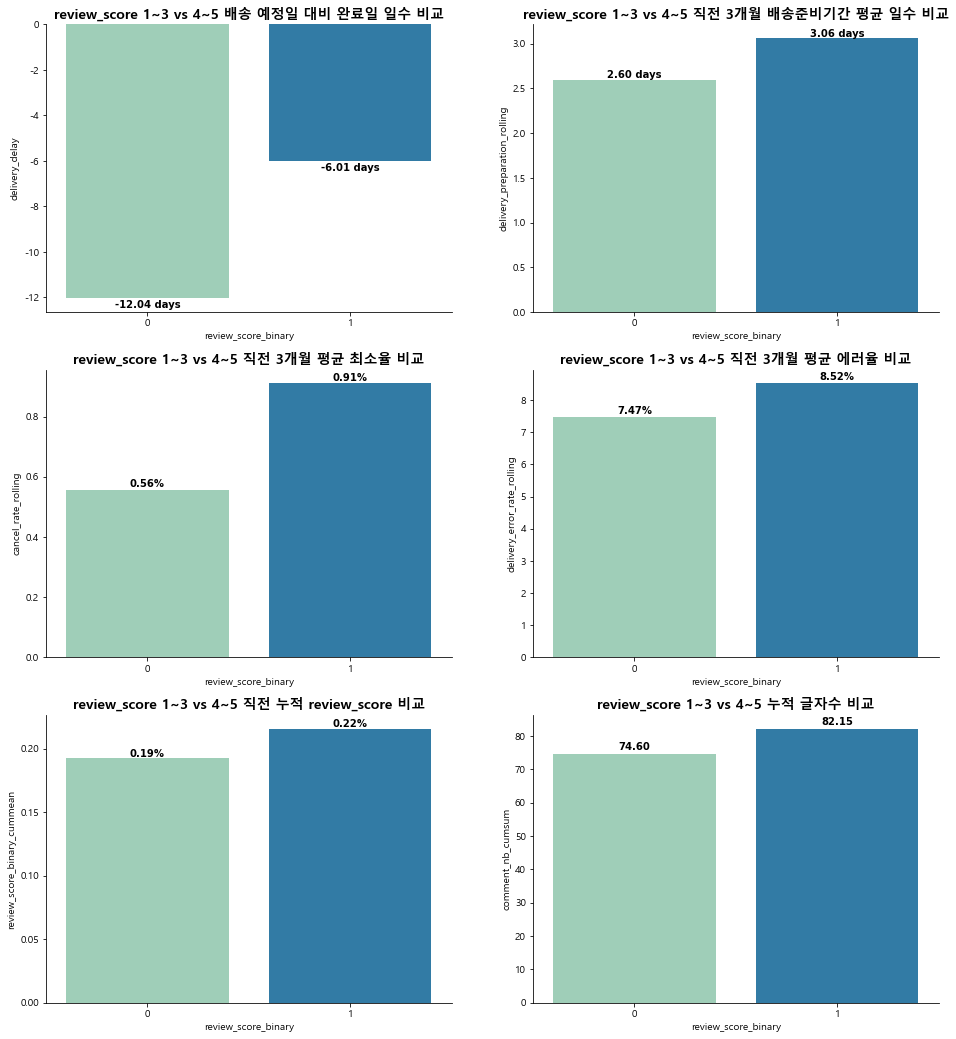

In [84]:
fig = plt.figure(figsize = (16,18))
gs = GridSpec(3,2, figure = fig)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[2,0])
ax6 = fig.add_subplot(gs[2,1])

# delivery_delay
delay = df_temp3.groupby("review_score_binary").delivery_delay.mean().to_frame()*(-1)
sns.barplot(x = delay.index, y = delay.delivery_delay, palette="YlGnBu", ax = ax1)
for i in delay.index:
    ax1.annotate(s = f"{delay.delivery_delay[i]:.2f} days",
                xy = [i, delay.loc[i, "delivery_delay"]-0.3], va = "center", ha = "center",
                size = 10, fontweight = "bold", fontfamily = "Sans Serif")
ax1.set_title("review_score 1~3 vs 4~5 배송 예정일 대비 완료일 일수 비교", size = 14, fontweight = "bold")

#delivery_delay_rolling 3month
delay_3month = df_temp3.groupby("review_score_binary").delivery_preparation_rolling.mean().to_frame()
sns.barplot(x = delay_3month.index, y = delay_3month.delivery_preparation_rolling, palette="YlGnBu", ax = ax2)
for i in delay.index:
    ax2.annotate(s = f"{delay_3month.delivery_preparation_rolling[i]:.2f} days",
                xy = [i, delay_3month.loc[i, "delivery_preparation_rolling"]+0.05], va = "center", ha = "center",
                size = 10, fontweight = "bold", fontfamily = "Sans Serif")
ax2.set_title("review_score 1~3 vs 4~5 직전 3개월 배송준비기간 평균 일수 비교", size = 14, fontweight = "bold")

#cancel_rate_rolling 3month
cancel_rate_3month = df_temp3.groupby("review_score_binary").cancel_rate_rolling.mean().to_frame()
sns.barplot(x = cancel_rate_3month.index, y = cancel_rate_3month.cancel_rate_rolling, palette="YlGnBu", ax = ax3)
for i in delay.index:
    ax3.annotate(s = f"{cancel_rate_3month.cancel_rate_rolling[i]:.2f}%",
                xy = [i, cancel_rate_3month.loc[i, "cancel_rate_rolling"]+0.02], va = "center", ha = "center",
                size = 10, fontweight = "bold", fontfamily = "Sans Serif")
ax3.set_title("review_score 1~3 vs 4~5 직전 3개월 평균 최소율 비교", size = 14, fontweight = "bold")

#cancel_rate_rolling 3month
delay_error_rate_3month = df_temp3.groupby("review_score_binary").delivery_error_rate_rolling.mean().to_frame()
sns.barplot(x = delay_error_rate_3month.index, y = delay_error_rate_3month.delivery_error_rate_rolling, palette="YlGnBu", ax = ax4)
for i in delay.index:
    ax4.annotate(s = f"{delay_error_rate_3month.delivery_error_rate_rolling[i]:.2f}%",
                xy = [i, delay_error_rate_3month.loc[i, "delivery_error_rate_rolling"]+0.2], va = "center", ha = "center",
                size = 10, fontweight = "bold", fontfamily = "Sans Serif")
ax4.set_title("review_score 1~3 vs 4~5 직전 3개월 평균 에러율 비교", size = 14, fontweight = "bold")

#누적 review_score
delay_error_rate_3month = df_temp3.groupby("review_score_binary").review_score_binary_cummean.mean().to_frame()
sns.barplot(x = delay_error_rate_3month.index, y = delay_error_rate_3month.review_score_binary_cummean, palette="YlGnBu", ax = ax5)
for i in delay.index:
    ax5.annotate(s = f"{delay_error_rate_3month.review_score_binary_cummean[i]:.2f}%",
                xy = [i, delay_error_rate_3month.loc[i, "review_score_binary_cummean"]+0.004], va = "center", ha = "center",
                size = 10, fontweight = "bold", fontfamily = "Sans Serif")
ax5.set_title("review_score 1~3 vs 4~5 직전 누적 review_score 비교", size = 14, fontweight = "bold")

# #누적 코멘트 개수
delay_error_rate_3month = df_temp3.groupby("review_score_binary").comment_nb_cumsum.mean().to_frame()
sns.barplot(x = delay_error_rate_3month.index, y = delay_error_rate_3month.comment_nb_cumsum, palette="YlGnBu", ax = ax6)
for i in delay.index:
    ax6.annotate(s = f"{delay_error_rate_3month.comment_nb_cumsum[i]:.2f}",
                xy = [i, delay_error_rate_3month.loc[i, "comment_nb_cumsum"]+2], va = "center", ha = "center",
                size = 10, fontweight = "bold", fontfamily = "Sans Serif")
ax6.set_title("review_score 1~3 vs 4~5 누적 글자수 비교", size = 14, fontweight = "bold")

sns.despine()
plt.show()

# Modeling

## 변수 선택 및 변수 타입 분리

In [85]:
def reset_cols(df,estimated_date_col, criteria_date_col, period_col):
    estimated_date,criteria_date,period = df[estimated_date_col],df[criteria_date_col],df[period_col]
    
    if criteria_date < estimated_date:
        period = period
    else:
        period = 99999
    return period

In [86]:
reset_preparation_cols_partial = partial(reset_cols,
                             estimated_date_col = "order_estimated_delivery_date",
                             criteria_date_col = "order_delivered_carrier_date",
                             period_col = "delivery_preparation")

reset_delivered_cols_partial = partial(reset_cols,
                             estimated_date_col = "order_estimated_delivery_date",
                             criteria_date_col = "order_delivered_customer_date",
                             period_col = "delivery_preparation")

In [87]:
df_temp3["delivery_preparation"] = df_temp3.apply(lambda x : reset_preparation_cols_partial(x), axis = 1)
df_temp3["order_delivered_customer_date"] = df_temp3.apply(lambda x : reset_delivered_cols_partial(x), axis = 1)

In [88]:
#feature Eng 컬럼 기준
col_selected = ['review_score','review_score_binary','seller_state','customer_state',
                'item_nb', 'total_payment', 'freight_value', 'freight_value_rate','delivery_error',
                'product_description_lenght','product_photos_qty','product_category_upper','product_category_name_english',
                'delivery_preparation','delivery_periods',
                'review_score_binary_cummean', 'comment_nb_cumsum','delivery_preparation_rolling','delivery_delay_rolling',
                'delivery_error_rolling','delivery_error_rate_rolling','cancel_rolling','cancel_rate_rolling',]

df_model = df_temp3[col_selected].copy()

In [89]:
num_cols = ['item_nb', 'total_payment', 'freight_value', 'freight_value_rate',
            'delivery_preparation','delivery_periods','product_description_lenght','delivery_error',
            'product_photos_qty','review_score_binary_cummean','comment_nb_cumsum','delivery_preparation_rolling',
            'delivery_delay_rolling','delivery_error_rolling','delivery_error_rate_rolling','cancel_rolling','cancel_rate_rolling']
cat_cols = ['seller_state','customer_state','product_category_upper']

y_col = ["review_score_binary"]

df_model[cat_cols] = df_model[cat_cols].astype('category')

In [90]:
df_model[num_cols+cat_cols+y_col].describe(include = "all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
item_nb,96064.0,NaN,NaN,NaN,1.099559,0.458014,1.0,1.0,1.0,1.0,20.0
total_payment,96064.0,NaN,NaN,NaN,156.248745,217.412491,9.27,60.1175,102.03,171.85,13664.08
freight_value,96064.0,NaN,NaN,NaN,22.042335,20.500055,0.0,13.6,16.89,23.23,1794.96
freight_value_rate,96064.0,NaN,NaN,NaN,20.889533,12.639882,0.0,11.63,18.33,27.64,95.55
delivery_preparation,96064.0,NaN,NaN,NaN,1456.82369,11970.804002,0.0,1.0,2.0,4.0,99999.0
delivery_periods,96064.0,NaN,NaN,NaN,23.277763,8.684078,2.0,18.0,23.0,28.0,155.0
product_description_lenght,96064.0,NaN,NaN,NaN,793.015771,654.293392,4.0,348.0,607.0,995.0,3992.0
delivery_error,96064.0,NaN,NaN,NaN,0.079874,0.271099,0.0,0.0,0.0,0.0,1.0
product_photos_qty,96064.0,NaN,NaN,NaN,2.24569,1.744645,1.0,1.0,2.0,3.0,20.0
review_score_binary_cummean,96064.0,NaN,NaN,NaN,0.197641,0.137926,0.0,0.120295,0.2,0.268041,1.0


In [91]:
fill_columns = df_model.columns[df_model.columns.str.contains("rolling")].tolist()

In [92]:
df_model[fill_columns] = df_model[fill_columns].fillna(99999).copy()

## train & testset 생성

## 모델 성능 개선

### 기본 상태로 LGBM 모델 적합

In [93]:
num_cols_origin = ['item_nb', 'total_payment', 'freight_value',
            'product_description_lenght','product_photos_qty']
cat_cols_origin = ['seller_state','customer_state','product_category_name_english']

y_col = ["review_score_binary"]


In [94]:
X = df_model[cat_cols_origin + num_cols_origin]
y = df_model[y_col]

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.5, random_state=0)

cat_encoder = OneHotEncoder()
num_imputer = SimpleImputer()

preprocessing = ColumnTransformer([('cat', cat_encoder, cat_cols_origin),
                                   ('num', num_imputer, num_cols_origin)])
lgbm = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', LGBMClassifier(random_state=0))])

kf = KFold(n_splits=5)
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
dict_results = cross_validate(estimator=lgbm, X=X_train, y=y_train, cv=kf, scoring=metrics)

for k, v in dict_results.items():
    print(k, round(np.nanmean(v), 4))

print("*"*50)
lgbm.fit(X_train,y_train)
y_pred = lgbm.predict(X_test)
print('AUC : {:.3f}'.format(roc_auc_score(y_test,  y_pred)))
print(classification_report(y_test, y_pred))

fit_time 0.1949
score_time 0.0582
test_accuracy 0.7753
test_precision 0.4774
test_recall 0.008
test_f1 0.0157
test_roc_auc 0.5891
**************************************************
AUC : 0.503
              precision    recall  f1-score   support

           0       0.78      1.00      0.87     37212
           1       0.50      0.01      0.01     10820

    accuracy                           0.77     48032
   macro avg       0.64      0.50      0.44     48032
weighted avg       0.71      0.77      0.68     48032



<AxesSubplot:>

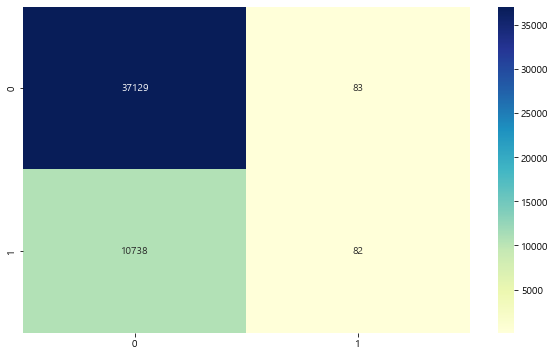

In [96]:
cm = confusion_matrix(y_test, y_pred)
fig,ax = plt.subplots(figsize = (10,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='YlGnBu')

### Feature Eng 변수 포함 LGBM 모델 적합

In [97]:
X = df_model[cat_cols + num_cols]
y = df_model[y_col]

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.5, random_state=0)

cat_encoder = OneHotEncoder()
num_imputer = SimpleImputer()

preprocessing = ColumnTransformer([('cat', cat_encoder, cat_cols),
                                   ('num', num_imputer, num_cols)])
lgbm = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', LGBMClassifier(random_state=0))])

kf = KFold(n_splits=5)
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
dict_results = cross_validate(estimator=lgbm, X=X_train, y=y_train, cv=kf, scoring=metrics)

for k, v in dict_results.items():
    print(k, round(np.nanmean(v), 4))

print("*"*50)
lgbm.fit(X_train,y_train)
y_pred = lgbm.predict(X_test)
print('AUC : {:.3f}'.format(roc_auc_score(y_test,  y_pred)))
print(classification_report(y_test, y_pred))

fit_time 0.3054
score_time 0.0828
test_accuracy 0.8111
test_precision 0.7142
test_recall 0.2647
test_f1 0.3862
test_roc_auc 0.6921
**************************************************
AUC : 0.617
              precision    recall  f1-score   support

           0       0.82      0.97      0.89     37212
           1       0.72      0.27      0.39     10820

    accuracy                           0.81     48032
   macro avg       0.77      0.62      0.64     48032
weighted avg       0.80      0.81      0.78     48032



<AxesSubplot:>

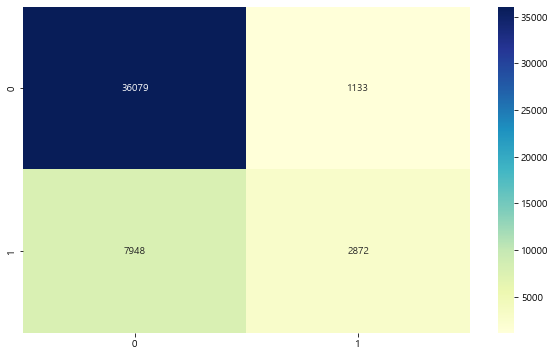

In [101]:
cm = confusion_matrix(y_test, y_pred)
fig,ax = plt.subplots(figsize = (10,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='YlGnBu')

### train & test 비율

In [102]:
best_f1 = 0
best_ratio = 0
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)

for i in range(1,51):
    print("*"*100)
    print(f"ratio : {i/100}")
    

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=i/100, random_state=0)

    cat_encoder = OneHotEncoder()
    num_imputer = SimpleImputer()

    preprocessing = ColumnTransformer([('cat', cat_encoder, cat_cols),
                                       ('num', num_imputer, num_cols)])
    lgbm = Pipeline([
        ('preprocess', preprocessing),
        ('classifier', LGBMClassifier(random_state=0))])

    oof_pred = []
    for i, (trn_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        x_train_, y_train_ = X_train.iloc[trn_idx, :], y_train.iloc[trn_idx]
        x_test_, y_test_ = X_train.iloc[val_idx, :], y_train.iloc[val_idx]

        lgbm.fit(x_train_, y_train_)

        oof_pred.append(lgbm.predict_proba(X_test)[:,1].tolist())
    
        
    pred = (pd.DataFrame(oof_pred).T.mean(axis=1)>0.5).astype(int)
    get_f1 = f1_score(y_test, pred)
    print(f"f1 : {get_f1}")

    if get_f1 > best_f1:
        best_f1 = get_f1
        best_ratio = i/100
#     except:
#         pass

print("*"*100)
print(f"best_ratio : {best_ratio} / best_f1 : {best_f1}")

****************************************************************************************************
ratio : 0.01
f1 : 0.33088235294117646
****************************************************************************************************
ratio : 0.02
f1 : 0.3501805054151624
****************************************************************************************************
ratio : 0.03
f1 : 0.3661645422943221
****************************************************************************************************
ratio : 0.04
f1 : 0.3840271877655055
****************************************************************************************************
ratio : 0.05
f1 : 0.39862068965517244
****************************************************************************************************
ratio : 0.06
f1 : 0.4027538726333907
****************************************************************************************************
ratio : 0.07
f1 : 0.39147670961347875
*******************************

ValueError: Found unknown categories ['AM'] in column 0 during transform

- trainset 비율이 적어질 경우 특정 카테고리 데이터가 부적절하게 나뉠 수 있음
- testset 비율이 어느 정도 적을수록 개선되지만, 어느 정도 테스트가 이뤄져야 하는 만큼 testset 비중을 0.21로 선정

### resampling

In [103]:
X = df_model[cat_cols + num_cols]
y = df_model[y_col]

#### undersampling : Random under sampling

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=0)

In [106]:
print("Before")
print(y_train.value_counts())

sampler = RandomUnderSampler()
X_train, y_train = sampler.fit_resample(X_train, y_train)
print(y_train.value_counts())

Before
review_score_binary
0                      59560
1                      17291
dtype: int64
review_score_binary
0                      17291
1                      17291
dtype: int64


In [107]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)
cat_encoder = OneHotEncoder()
num_imputer = SimpleImputer()

preprocessing = ColumnTransformer([('cat', cat_encoder, cat_cols),
                                   ('num', num_imputer, num_cols)])
lgbm = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', LGBMClassifier(random_state=0))])

oof_pred = []
for i, (trn_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    x_train_, y_train_ = X_train.iloc[trn_idx, :], y_train.iloc[trn_idx]

    lgbm.fit(x_train_, y_train_)

    oof_pred.append(lgbm.predict_proba(X_test)[:,1].tolist())
pred = (pd.DataFrame(oof_pred).T.mean(axis=1)>0.5).astype(int)

print('AUC : {:.3f}'.format(f1_score(y_test, pred)))
print('AUC : {:.3f}'.format(roc_auc_score(y_test,  pred)))
print(classification_report(y_test, pred))

AUC : 0.468
AUC : 0.657
              precision    recall  f1-score   support

           0       0.85      0.82      0.83     14896
           1       0.44      0.50      0.47      4317

    accuracy                           0.74     19213
   macro avg       0.64      0.66      0.65     19213
weighted avg       0.76      0.74      0.75     19213



#### Over Sampling: Random Over Sampling

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=0)

In [109]:
print("Before")
print(y_train.value_counts())

sampler = RandomOverSampler()
X_train, y_train = sampler.fit_resample(X_train, y_train)
print(y_train.value_counts())

Before
review_score_binary
0                      59560
1                      17291
dtype: int64
review_score_binary
0                      59560
1                      59560
dtype: int64


In [110]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)
cat_encoder = OneHotEncoder()
num_imputer = SimpleImputer()

preprocessing = ColumnTransformer([('cat', cat_encoder, cat_cols),
                                   ('num', num_imputer, num_cols)])
lgbm = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', LGBMClassifier(random_state=0))])

oof_pred = []
for i, (trn_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    x_train_, y_train_ = X_train.iloc[trn_idx, :], y_train.iloc[trn_idx]

    lgbm.fit(x_train_, y_train_)

    oof_pred.append(lgbm.predict_proba(X_test)[:,1].tolist())
pred = (pd.DataFrame(oof_pred).T.mean(axis=1)>0.5).astype(int)

print('AUC : {:.3f}'.format(f1_score(y_test, pred)))
print('AUC : {:.3f}'.format(roc_auc_score(y_test,  pred)))
print(classification_report(y_test, pred))

AUC : 0.463
AUC : 0.654
              precision    recall  f1-score   support

           0       0.85      0.84      0.84     14896
           1       0.45      0.47      0.46      4317

    accuracy                           0.75     19213
   macro avg       0.65      0.65      0.65     19213
weighted avg       0.76      0.75      0.76     19213



- 실제 배송상 문제가 없는데 있다고 오분류 한거 보다, 문제가 있는데 없다고 오분류 한 것이 더 중요
- 따라서, Precision(실제 1인데 모델을 통해 1로 판단된 비율)이 더 큰 오버샘플링으로 진행

### 변수소거 by permutation_importance

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=0)

print("Before")
print(y_train.value_counts())

sampler = RandomOverSampler()
X_train, y_train = sampler.fit_resample(X_train, y_train)
print(y_train.value_counts())

Before
review_score_binary
0                      59560
1                      17291
dtype: int64
review_score_binary
0                      59560
1                      59560
dtype: int64


In [113]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)
cat_encoder = OneHotEncoder()
num_imputer = SimpleImputer()

preprocessing = ColumnTransformer([('cat', cat_encoder, cat_cols),
                                   ('num', num_imputer, num_cols)])
lgbm = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', LGBMClassifier(random_state=0))])

oof_pred = []
for i, (trn_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    x_train_, y_train_ = X_train.iloc[trn_idx, :], y_train.iloc[trn_idx]

    lgbm.fit(x_train_, y_train_)

    oof_pred.append(lgbm.predict_proba(X_test)[:,1].tolist())
pred = (pd.DataFrame(oof_pred).T.mean(axis=1)>0.5).astype(int)

print('F1 : {:.3f}'.format(f1_score(y_test, pred)))
print('AUC : {:.3f}'.format(roc_auc_score(y_test,  pred)))
print(classification_report(y_test, pred))

F1 : 0.466
AUC : 0.656
              precision    recall  f1-score   support

           0       0.85      0.84      0.84     14896
           1       0.46      0.47      0.47      4317

    accuracy                           0.76     19213
   macro avg       0.65      0.66      0.65     19213
weighted avg       0.76      0.76      0.76     19213



#### permutation importance 계산

In [114]:
def cal_permutation_importance_df(result, cat_col, num_col):
    #importance dataframe
    result_df = pd.DataFrame(result.importances.T)
    result_df.columns = cat_col + num_col
    
    return result_df.describe().T[["mean","std"]].sort_values("mean",ascending = False)

In [115]:
result = permutation_importance(estimator=lgbm,X = X_test, y = y_test,n_repeats=50)

In [116]:
cal_permutation_importance_df(result, cat_cols, num_cols)

,mean,std
delivery_error,0.057809,0.001626
delivery_preparation,0.016265,0.001368
item_nb,0.012034,0.001107
customer_state,0.005739,0.001224
freight_value,0.005163,0.000865
freight_value_rate,0.003116,0.000701
total_payment,0.001400,0.000825
cancel_rolling,0.000507,0.000434
cancel_rate_rolling,-0.000034,0.000079
delivery_delay_rolling,-0.000132,0.000956


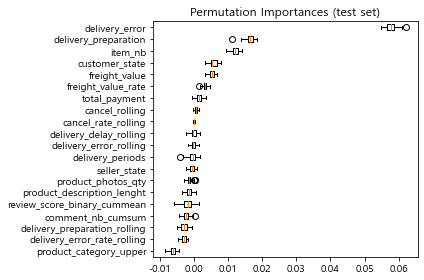

In [117]:
sorted_index = result.importances_mean.argsort()
fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_index].T,
           vert=False, labels=X_test.columns[sorted_index])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

#### permutation importance로 중요도 낮은 변수 하나씩 제거하며 성능 확인

In [118]:
X_cols = X_test.columns[sorted_index]

X_train_pop_col = X_train.copy()
X_test_pop_col = X_test.copy()

cat_cols_pop = cat_cols.copy()
num_cols_pop = num_cols.copy()

In [119]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)
for s in X_cols:
    if X_train_pop_col.shape[1] > 1:
        print(f"제거한 변수 : {s}")

        if s in cat_cols:
            cat_cols_pop.remove(s)
        else:
            num_cols_pop.remove(s)

        del X_train_pop_col[s]
        del X_test_pop_col[s]
    
    
        cat_encoder = OneHotEncoder()
        num_pipe = Pipeline([('imputer', SimpleImputer())])

        preprocessing = ColumnTransformer([('cat', cat_encoder, cat_cols_pop),
                                           ('num', num_pipe, num_cols_pop)])
        lgbm = Pipeline([
                        ('preprocess', preprocessing),
                        ('classifier', LGBMClassifier(random_state=0))])
        oof_pred = []
        for i, (trn_idx, val_idx) in enumerate(skf.split(X_train_pop_col, y_train)):
            x_train_, y_train_ = X_train_pop_col.iloc[trn_idx, :], y_train.iloc[trn_idx]
            x_test_, y_test_ = X_train_pop_col.iloc[val_idx, :], y_train.iloc[val_idx]

            lgbm.fit(x_train_, y_train_)

            oof_pred.append(lgbm.predict_proba(X_test_pop_col)[:,1].tolist())
        y_pred = (pd.DataFrame(oof_pred).T.mean(axis=1)>0.5).astype(int)
        
        print('AUC : {:.3f}'.format(roc_auc_score(y_test, y_pred)))
        print(classification_report(y_test, y_pred))
        print("*"*30)   
    else:
        print(f"남은 변수 : {s}")

제거한 변수 : product_category_upper
AUC : 0.655
              precision    recall  f1-score   support

           0       0.85      0.84      0.84     14896
           1       0.46      0.47      0.47      4317

    accuracy                           0.76     19213
   macro avg       0.65      0.66      0.65     19213
weighted avg       0.76      0.76      0.76     19213

******************************
제거한 변수 : delivery_error_rate_rolling
AUC : 0.655
              precision    recall  f1-score   support

           0       0.85      0.84      0.84     14896
           1       0.46      0.47      0.47      4317

    accuracy                           0.76     19213
   macro avg       0.65      0.66      0.65     19213
weighted avg       0.76      0.76      0.76     19213

******************************
제거한 변수 : delivery_preparation_rolling
AUC : 0.658
              precision    recall  f1-score   support

           0       0.85      0.84      0.85     14896
           1       0.47      0.4

- 하위 3개 변수 제거

In [121]:
del_list =  ["product_category_upper","delivery_error_rate_rolling","delivery_preparation_rolling"]

In [136]:
num_cols = list(set(num_cols) - set(del_list))
cat_cols = list(set(cat_cols) - set(del_list))

### 하이퍼파라미터 조정

In [137]:
from sklearn.model_selection import GridSearchCV

In [138]:
X = df_model[cat_cols + num_cols]
y = df_model[y_col]

In [139]:
X_GetDummies = pd.get_dummies(X, columns = cat_cols)

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X_GetDummies,y, test_size=0.21, random_state=0)
print("Before")
print(y_train.value_counts())

sampler = RandomOverSampler()
X_train, y_train = sampler.fit_resample(X_train, y_train)
print(y_train.value_counts())

Before
review_score_binary
0                      58819
1                      17071
dtype: int64
review_score_binary
0                      58819
1                      58819
dtype: int64


#### learning_rate 0.01 ~ 0.1 간격 => 0.0955

In [141]:
n_estimators = [30]
max_depth = [5]
learning_rate = np.linspace(0.01,0.1,21)


gridsearch = pd.DataFrame(
    np.array([(x,y,z) for x in n_estimators for y in max_depth for z in learning_rate]))\
                   .rename(columns = {0 : "n_estimators", 1 : "max_depth", 2 : "learning_rate"})
gridsearch[["n_estimators","max_depth"]] = gridsearch[["n_estimators","max_depth"]].astype(int)

n_estimators = gridsearch.n_estimators.tolist()
max_depth = gridsearch.max_depth.tolist()
learning_rate = gridsearch.learning_rate.tolist()

i = 1
length = len(n_estimators)
best_f1_score = [0,0]
f1_score_list = []
best_params = []
for x,y,z in zip(n_estimators,max_depth,learning_rate):
    if (i/length*100)%5 == 0:
        print(f"[{i}번] {round(i/length*100)}% 완료")
    print(f"n_estimators : {x}\nmax_depth : {y}\nlearning_rate : {z}")
    lgbm = LGBMClassifier(random_state=0,n_estimators=x, max_depth=y, learning_rate=z)
    oof_pred = []
    for (trn_idx, val_idx) in skf.split(X_train, y_train):
        x_train_, y_train_ = X_train.iloc[trn_idx, :], y_train.iloc[trn_idx]

        lgbm.fit(x_train_, y_train_)

        oof_pred.append(lgbm.predict_proba(X_test)[:,1].tolist())
    y_pred = (pd.DataFrame(oof_pred).T.mean(axis=1)>0.5).astype(int)
    

    f1 = f1_score(y_test,y_pred)
    
    f1_score_list.append(f1)
    if f1 > best_f1_score[1]:
        best_f1_score = [i-1,f1]
        best_params = [x,y,z]
    print('AUC : {:.3f}'.format(roc_auc_score(y_test, y_pred)))
    print(f"F1 Score : {f1}")
    print(classification_report(y_test, y_pred))
    i +=1
    print("*"*50)
print(best_f1_score)
print(best_params)

n_estimators : 30
max_depth : 5
learning_rate : 0.01
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC : 0.645
F1 Score : 0.4499001527076237
              precision    recall  f1-score   support

           0       0.84      0.87      0.85     15637
           1       0.48      0.42      0.45      4537

    accuracy                           0.77     20174
   macro avg       0.66      0.65    

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC : 0.647
F1 Score : 0.452342111395945
              precision    recall  f1-score   support

           0       0.84      0.87      0.85     15637
           1       0.48      0.43      0.45      4537

    accuracy                           0.77     20174
   macro avg       0.66      0.65      0.65     20174
weighted avg       0.76      0.77      0.76     20174

**************************************************
n_estimators : 30
max_depth : 5
learning_rate : 0.046000000000000006
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leav

AUC : 0.649
F1 Score : 0.4564488143435512
              precision    recall  f1-score   support

           0       0.84      0.86      0.85     15637
           1       0.48      0.43      0.46      4537

    accuracy                           0.77     20174
   macro avg       0.66      0.65      0.65     20174
weighted avg       0.76      0.77      0.76     20174

**************************************************
n_estimators : 30
max_depth : 5
learning_rate : 0.0775
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Ligh

 #### learning_rate 0.05 ~ 0.15 => 0.145

In [142]:
n_estimators = [30]
max_depth = [5]
learning_rate = np.linspace(0.05,0.15,21)


gridsearch = pd.DataFrame(
    np.array([(x,y,z) for x in n_estimators for y in max_depth for z in learning_rate]))\
                   .rename(columns = {0 : "n_estimators", 1 : "max_depth", 2 : "learning_rate"})
gridsearch[["n_estimators","max_depth"]] = gridsearch[["n_estimators","max_depth"]].astype(int)

n_estimators = gridsearch.n_estimators.tolist()
max_depth = gridsearch.max_depth.tolist()
learning_rate = gridsearch.learning_rate.tolist()

i = 1
length = len(n_estimators)
best_f1_score = [0,0,0]
f1_score_list = []
best_params = []
for x,y,z in zip(n_estimators,max_depth,learning_rate):
    if (i/length*100)%5 == 0:
        print(f"[{i}번] {round(i/length*100)}% 완료")
    print(f"n_estimators : {x}\nmax_depth : {y}\nlearning_rate : {z}")
    lgbm = LGBMClassifier(random_state=0,n_estimators=x, max_depth=y, learning_rate=z)
    oof_pred = []
    for (trn_idx, val_idx) in skf.split(X_train, y_train):
        x_train_, y_train_ = X_train.iloc[trn_idx, :], y_train.iloc[trn_idx]

        lgbm.fit(x_train_, y_train_)

        oof_pred.append(lgbm.predict_proba(X_test)[:,1].tolist())
    y_pred = (pd.DataFrame(oof_pred).T.mean(axis=1)>0.5).astype(int)
    

    f1 = f1_score(y_test,y_pred)
    
    f1_score_list.append(f1)
    if f1 > best_f1_score[1]:
        best_f1_score = [i-1,f1]
        best_params = [x,y,z]
    print('AUC : {:.3f}'.format(roc_auc_score(y_test, y_pred)))
    print(f"F1 Score : {f1}")
    print(classification_report(y_test, y_pred))
    i +=1
    print("*"*50)
print(best_f1_score)
print(best_params)

n_estimators : 30
max_depth : 5
learning_rate : 0.05
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC : 0.648
F1 Score : 0.4544714501686243
              precision    recall  f1-score   support

           0       0.84      0.87      0.85     15637
           1       0.48      0.43      0.45      4537

    accuracy                           0.77     20174
   macro avg       0.66      0.65    

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC : 0.649
F1 Score : 0.45627815640522124
              precision    recall  f1-score   support

           0       0.84      0.86      0.85     15637
           1       0.48      0.44      0.46      4537

    accuracy                           0.77     20174
   macro avg       0.66      0.65      0.65     20174
weighted avg       0.76      0.77      0.76     20174

**************************************************
n_estimators : 30
max_depth : 5
learning_rate : 0.09
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Light

AUC : 0.652
F1 Score : 0.4607223476297969
              precision    recall  f1-score   support

           0       0.84      0.85      0.85     15637
           1       0.47      0.45      0.46      4537

    accuracy                           0.76     20174
   macro avg       0.66      0.65      0.65     20174
weighted avg       0.76      0.76      0.76     20174

**************************************************
n_estimators : 30
max_depth : 5
learning_rate : 0.12499999999999999
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leav

 #### learning_rate 0.1 ~ 0.2 간격 => 0.185

In [143]:
n_estimators = [30]
max_depth = [5]
learning_rate = np.linspace(0.1,0.2,21)


gridsearch = pd.DataFrame(
    np.array([(x,y,z) for x in n_estimators for y in max_depth for z in learning_rate]))\
                   .rename(columns = {0 : "n_estimators", 1 : "max_depth", 2 : "learning_rate"})
gridsearch[["n_estimators","max_depth"]] = gridsearch[["n_estimators","max_depth"]].astype(int)

n_estimators = gridsearch.n_estimators.tolist()
max_depth = gridsearch.max_depth.tolist()
learning_rate = gridsearch.learning_rate.tolist()

i = 1
length = len(n_estimators)
best_f1_score = [0,0,0]
f1_score_list = []
best_params = []
for x,y,z in zip(n_estimators,max_depth,learning_rate):
    if (i/length*100)%5 == 0:
        print(f"[{i}번] {round(i/length*100)}% 완료")
    print(f"n_estimators : {x}\nmax_depth : {y}\nlearning_rate : {z}")
    lgbm = LGBMClassifier(random_state=0,n_estimators=x, max_depth=y, learning_rate=z)
    oof_pred = []
    for (trn_idx, val_idx) in skf.split(X_train, y_train):
        x_train_, y_train_ = X_train.iloc[trn_idx, :], y_train.iloc[trn_idx]

        lgbm.fit(x_train_, y_train_)

        oof_pred.append(lgbm.predict_proba(X_test)[:,1].tolist())
    y_pred = (pd.DataFrame(oof_pred).T.mean(axis=1)>0.5).astype(int)
    

    f1 = f1_score(y_test,y_pred)
    
    f1_score_list.append(f1)
    if f1 > best_f1_score[1]:
        best_f1_score = [i-1,f1]
        best_params = [x,y,z]
    print('AUC : {:.3f}'.format(roc_auc_score(y_test, y_pred)))
    print(f"F1 Score : {f1}")
    print(classification_report(y_test, y_pred))
    i +=1
    print("*"*50)
print(best_f1_score)
print(best_params)

n_estimators : 30
max_depth : 5
learning_rate : 0.1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC : 0.650
F1 Score : 0.45794713353930655
              precision    recall  f1-score   support

           0       0.84      0.86      0.85     15637
           1       0.48      0.44      0.46      4537

    accuracy                           0.77     20174
   macro avg       0.66      0.65    

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC : 0.651
F1 Score : 0.4588288086156608
              precision    recall  f1-score   support

           0       0.84      0.85      0.85     15637
           1       0.47      0.45      0.46      4537

    accuracy                           0.76     20174
   macro avg       0.65      0.65      0.65     20174
weighted avg       0.76      0.76      0.76     20174

**************************************************
n_estimators : 30
max_depth : 5
learning_rate : 0.14
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightG

AUC : 0.652
F1 Score : 0.4601808956540922
              precision    recall  f1-score   support

           0       0.84      0.84      0.84     15637
           1       0.46      0.46      0.46      4537

    accuracy                           0.76     20174
   macro avg       0.65      0.65      0.65     20174
weighted avg       0.76      0.76      0.76     20174

**************************************************
n_estimators : 30
max_depth : 5
learning_rate : 0.175
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Light

#### n_estimators 20 ~ 1000=> 40

In [144]:
n_estimators = np.linspace(20,1000,50)
max_depth = [5]
learning_rate = [0.185]


gridsearch = pd.DataFrame(
    np.array([(x,y,z) for x in n_estimators for y in max_depth for z in learning_rate]))\
                   .rename(columns = {0 : "n_estimators", 1 : "max_depth", 2 : "learning_rate"})
gridsearch[["n_estimators","max_depth"]] = gridsearch[["n_estimators","max_depth"]].astype(int)

n_estimators = gridsearch.n_estimators.tolist()
max_depth = gridsearch.max_depth.tolist()
learning_rate = gridsearch.learning_rate.tolist()

i = 1
length = len(n_estimators)
best_f1_score = [0,0,0]
f1_score_list = []
best_params = []
for x,y,z in zip(n_estimators,max_depth,learning_rate):
    if (i/length*100)%5 == 0:
        print(f"[{i}번] {round(i/length*100)}% 완료")
    print(f"n_estimators : {x}\nmax_depth : {y}\nlearning_rate : {z}")
    lgbm = LGBMClassifier(random_state=0,n_estimators=x, max_depth=y, learning_rate=z)
    oof_pred = []
    for (trn_idx, val_idx) in skf.split(X_train, y_train):
        x_train_, y_train_ = X_train.iloc[trn_idx, :], y_train.iloc[trn_idx]

        lgbm.fit(x_train_, y_train_)

        oof_pred.append(lgbm.predict_proba(X_test)[:,1].tolist())
    y_pred = (pd.DataFrame(oof_pred).T.mean(axis=1)>0.5).astype(int)
    

    f1 = f1_score(y_test,y_pred)
    
    f1_score_list.append(f1)
    if f1 > best_f1_score[1]:
        best_f1_score = [i-1,f1]
        best_params = [x,y,z]
    print('AUC : {:.3f}'.format(roc_auc_score(y_test, y_pred)))
    print(f"F1 Score : {f1}")
    print(classification_report(y_test, y_pred))
    i +=1
    print("*"*50)
print(best_f1_score)
print(best_params)

n_estimators : 20
max_depth : 5
learning_rate : 0.185
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC : 0.651
F1 Score : 0.4596900965641141
              precision    recall  f1-score   support

           0       0.84      0.85      0.85     15637
           1       0.47      0.45      0.46      4537

    accuracy                           0.76     20174
   macro avg       0.66      0.65   

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC : 0.650
F1 Score : 0.4567728008634646
              precision    recall  f1-score   support

           0       0.84      0.83      0.84     15637
           1       0.45      0.47      0.46      4537

    accuracy                           0.75     20174
   macro avg       0.65      0.65      0.65     20174
weighted avg       0.75      0.75      0.75     20174

**************************************************
n_estimators : 180
max_depth : 5
learning_rate : 0.185
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Ligh

AUC : 0.649
F1 Score : 0.45613653658006303
              precision    recall  f1-score   support

           0       0.84      0.84      0.84     15637
           1       0.45      0.46      0.46      4537

    accuracy                           0.75     20174
   macro avg       0.65      0.65      0.65     20174
weighted avg       0.75      0.75      0.75     20174

**************************************************
n_estimators : 320
max_depth : 5
learning_rate : 0.185
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Lig

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC : 0.648
F1 Score : 0.45492341356673965
              precision    recall  f1-score   support

           0       0.84      0.84      0.84     15637
           1       0.45      0.46      0.45      4537

    accuracy                           0.75     20174
   macro avg       0.65      0.65      0.65     20174
weighted avg       0.75      0.75      0.75     20174

**************************************************
n_estimators : 480
max_depth : 5
learning_rate : 0.185
[Lig

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC : 0.647
F1 Score : 0.45334796926454446
              precision    recall  f1-score   support

           0       0.84      0.84      0.84     15637
           1       0.45      0.46      0.45      4537

    accuracy                           0.75     20174
   macro avg       0.65      0.65      0.65     20174
weighted avg       0.75      0.75      0.75     20174

**************************************************
n_estimators : 620
max_depth : 5
learning_rate : 0.185
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Lig

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC : 0.645
F1 Score : 0.4493859940258878
              precision    recall  f1-score   support

           0       0.84      0.84      0.84     15637
           1       0.45      0.45      0.45      4537

    accuracy                           0.75     20174
   macro avg       0.65      0.64      0.65     20174
weighted avg       0.75      0.75      0.75     20174

**************************************************
n_estimators : 780
max_depth : 5
learning_rate : 0.185
[Ligh

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC : 0.646
F1 Score : 0.451276359600444
              precision    recall  f1-score   support

           0       0.84      0.84      0.84     15637
           1       0.45      0.45      0.45      4537

    accuracy                           0.75     20174
   macro avg       0.65      0.65      0.65     20174
weighted avg       0.75      0.75      0.75     20174

**************************************************
n_estimators : 920
max_depth : 5
learning_rate : 0.185
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Light

#### n_estimators 5 ~ 60 간격 => 35

In [145]:
n_estimators = np.linspace(5,60,12)
max_depth = [5]
learning_rate = [0.185]


gridsearch = pd.DataFrame(
    np.array([(x,y,z) for x in n_estimators for y in max_depth for z in learning_rate]))\
                   .rename(columns = {0 : "n_estimators", 1 : "max_depth", 2 : "learning_rate"})
gridsearch[["n_estimators","max_depth"]] = gridsearch[["n_estimators","max_depth"]].astype(int)

n_estimators = gridsearch.n_estimators.tolist()
max_depth = gridsearch.max_depth.tolist()
learning_rate = gridsearch.learning_rate.tolist()

i = 1
length = len(n_estimators)
best_f1_score = [0,0,0]
f1_score_list = []
best_params = []
for x,y,z in zip(n_estimators,max_depth,learning_rate):
    if (i/length*100)%5 == 0:
        print(f"[{i}번] {round(i/length*100)}% 완료")
    print(f"n_estimators : {x}\nmax_depth : {y}\nlearning_rate : {z}")
    lgbm = LGBMClassifier(random_state=0,n_estimators=x, max_depth=y, learning_rate=z)
    oof_pred = []
    for (trn_idx, val_idx) in skf.split(X_train, y_train):
        x_train_, y_train_ = X_train.iloc[trn_idx, :], y_train.iloc[trn_idx]

        lgbm.fit(x_train_, y_train_)

        oof_pred.append(lgbm.predict_proba(X_test)[:,1].tolist())
    y_pred = (pd.DataFrame(oof_pred).T.mean(axis=1)>0.5).astype(int)
    

    f1 = f1_score(y_test,y_pred)
    
    f1_score_list.append(f1)
    if f1 > best_f1_score[1]:
        best_f1_score = [i-1,f1]
        best_params = [x,y,z]
    print('AUC : {:.3f}'.format(roc_auc_score(y_test, y_pred)))
    print(f"F1 Score : {f1}")
    print(classification_report(y_test, y_pred))
    i +=1
    print("*"*50)
print(best_f1_score)
print(best_params)

n_estimators : 5
max_depth : 5
learning_rate : 0.185
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC : 0.647
F1 Score : 0.45324232081911264
              precision    recall  f1-score   support

           0       0.84      0.86      0.85     15637
           1       0.47      0.44      0.45      4537

    accuracy                           0.76     20174
   macro avg       0.65      0.65   

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC : 0.653
F1 Score : 0.46172274855711637
              precision    recall  f1-score   support

           0       0.84      0.84      0.84     15637
           1       0.46      0.47      0.46      4537

    accuracy                           0.75     20174
   macro avg       0.65      0.65      0.65     20174
weighted avg       0.76      0.75      0.76     20174

**************************************************
[9번] 75% 완료
n_estimators : 45
max_depth : 5
learning_rate : 0.185
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leave

#### max_depth None+ -1 + 1 ~ 30, 1 간격 => 5

In [146]:
n_estimators = [35]
max_depth = [None, -1]+np.linspace(1,20,20).tolist()
max_depth = [int(s) if type(s)==float else s for s in max_depth]
learning_rate = [0.185]


gridsearch = pd.DataFrame(
    np.array([(x,y,z) for x in n_estimators for y in max_depth for z in learning_rate]))\
                   .rename(columns = {0 : "n_estimators", 1 : "max_depth", 2 : "learning_rate"})

n_estimators = gridsearch.n_estimators.tolist()
max_depth = gridsearch.max_depth.tolist()
learning_rate = gridsearch.learning_rate.tolist()

i = 1
length = len(n_estimators)
best_f1_score = [0,0,0]
f1_score_list = []
best_params = []
for x,y,z in zip(n_estimators,max_depth,learning_rate):
    if (i/length*100)%5 == 0:
        print(f"[{i}번] {round(i/length*100)}% 완료")
    print(f"n_estimators : {x}\nmax_depth : {y}\nlearning_rate : {z}")
    
    lgbm = LGBMClassifier(random_state=0,n_estimators=x, max_depth=y, learning_rate=z)
    oof_pred = []
    for (trn_idx, val_idx) in skf.split(X_train, y_train):
        x_train_, y_train_ = X_train.iloc[trn_idx, :], y_train.iloc[trn_idx]

        lgbm.fit(x_train_, y_train_)

        oof_pred.append(lgbm.predict_proba(X_test)[:,1].tolist())
    y_pred = (pd.DataFrame(oof_pred).T.mean(axis=1)>0.5).astype(int)
    

    f1 = f1_score(y_test,y_pred)
    
    f1_score_list.append(f1)
    if f1 > best_f1_score[1]:
        best_f1_score = [i-1,f1]
        best_params = [x,y,z]
    print('AUC : {:.3f}'.format(roc_auc_score(y_test, y_pred)))
    print(f"F1 Score : {f1}")
    print(classification_report(y_test, y_pred))
    i +=1
    print("*"*50)
print(best_f1_score)
print(best_params)

n_estimators : 35
max_depth : None
learning_rate : 0.185
AUC : 0.653
F1 Score : 0.4612036130155621
              precision    recall  f1-score   support

           0       0.84      0.84      0.84     15637
           1       0.46      0.47      0.46      4537

    accuracy                           0.75     20174
   macro avg       0.65      0.65      0.65     20174
weighted avg       0.76      0.75      0.76     20174

**************************************************
n_estimators : 35
max_depth : -1
learning_rate : 0.185
AUC : 0.653
F1 Score : 0.4612036130155621
              precision    recall  f1-score   support

           0       0.84      0.84      0.84     15637
           1       0.46      0.47      0.46      4537

    accuracy                           0.75     20174
   macro avg       0.65      0.65      0.65     20174
weighted avg       0.76      0.75      0.76     20174

**************************************************
n_estimators : 35
max_depth : 1
learning_rate : 

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC : 0.652
F1 Score : 0.4605234696084794
              precision    recall  f1-score   support

           0       0.84      0.84      0.84     15637
           1       0.45      0.47      0.46      4537

    accuracy                           0.75     20174
   macro avg       0.65      0.65      0.65     20174
weighted avg       0.76      0.75      0.75     20174

**************************************************
n_estimators : 35
max_depth : 11
learning_rate : 0.185
[Ligh

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC : 0.653
F1 Score : 0.4614210985178727
              precision    recall  f1-score   support

           0       0.84      0.84      0.84     15637
           1       0.46      0.47      0.46      4537

    accuracy                           0.76     20174
   macro avg       0.65      0.65      0.65     20174
weighted avg       0.76      0.76      0.76     20174

**************************************************
n_estimators : 35
max_depth : 18
learning_rate : 0.185
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Ligh

#### boosting_types => gbdt

In [147]:
boosting_types = ['gbdt','dart','goss']

i = 1
length = len(n_estimators)
best_f1_score = [0,0]
f1_score_list = []
best_params = []
for s in boosting_types:
    if (i/length*100)%5 == 0:
        print(f"[{i}번] {round(i/length*100)}% 완료")
    print(f"boosting type : {s}")
    
    lgbm = LGBMClassifier(random_state=0,
                          boosting_type = s,
                          n_estimators=35,
                          max_depth=5,
                          learning_rate=0.185)
    oof_pred = []
    for (trn_idx, val_idx) in skf.split(X_train, y_train):
        x_train_, y_train_ = X_train.iloc[trn_idx, :], y_train.iloc[trn_idx]

        lgbm.fit(x_train_, y_train_)

        oof_pred.append(lgbm.predict_proba(X_test)[:,1].tolist())
    y_pred = (pd.DataFrame(oof_pred).T.mean(axis=1)>0.5).astype(int)
    

    f1 = f1_score(y_test,y_pred)
    
    f1_score_list.append(f1)
    if f1 > best_f1_score[1]:
        best_f1_score = [i-1,f1]
        best_params = [x,y,z]
    print('AUC : {:.3f}'.format(roc_auc_score(y_test, y_pred)))
    print(f"F1 Score : {f1}")
    print(classification_report(y_test, y_pred))
    i +=1
    print("*"*50)
print(best_f1_score)
print(best_params)

boosting type : gbdt
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC : 0.653
F1 Score : 0.46259692038877365
              precision    recall  f1-score   support

           0       0.84      0.84      0.84     15637
           1       0.46      0.47      0.46      4537

    accuracy                           0.76     20174
   macro avg       0.65      0.65      0.65     20174
weighted avg  

#### num_leaves 10 ~ 50, 5 간격 => 30

In [148]:
num_leaves_list = np.linspace(10,50,5).tolist()
num_leaves_list = [int(i) for i in num_leaves_list]
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)
i = 1
length = len(num_leaves_list)
best_f1_score = [0,0]
f1_score_list = []
best_params = []
for num in num_leaves_list:
    if (i/length*100)%5 == 0:
        print(f"[{i}번] {round(i/length*100)}% 완료")
    print(f"num_leaves : {num}")
    
    lgbm = LGBMClassifier(random_state=0,
                          num_leaves = num,
                          boosting_type = 'gbdt',
                          n_estimators=35,
                          max_depth=5,
                          learning_rate=0.185)
    
    oof_pred = []
    for (trn_idx, val_idx) in skf.split(X_train, y_train):
        x_train_, y_train_ = X_train.iloc[trn_idx, :], y_train.iloc[trn_idx]

        lgbm.fit(x_train_, y_train_)

        oof_pred.append(lgbm.predict_proba(X_test)[:,1].tolist())
    y_pred = (pd.DataFrame(oof_pred).T.mean(axis=1)>0.5).astype(int)
    

    f1 = f1_score(y_test,y_pred)
    
    f1_score_list.append(f1)
    if f1 > best_f1_score[1]:
        best_f1_score = [i-1,f1]
        best_params = [num]
    print('AUC : {:.3f}'.format(roc_auc_score(y_test, y_pred)))
    print(f"F1 Score : {f1}")
    print(classification_report(y_test, y_pred))
    i +=1
    print("*"*50)
print(best_f1_score)
print(best_params)

[1번] 20% 완료
num_leaves : 10
AUC : 0.652
F1 Score : 0.4599890530925014
              precision    recall  f1-score   support

           0       0.84      0.84      0.84     15637
           1       0.46      0.46      0.46      4537

    accuracy                           0.76     20174
   macro avg       0.65      0.65      0.65     20174
weighted avg       0.76      0.76      0.76     20174

**************************************************
[2번] 40% 완료
num_leaves : 20
AUC : 0.653
F1 Score : 0.4614373356704645
              precision    recall  f1-score   support

           0       0.84      0.84      0.84     15637
           1       0.46      0.46      0.46      4537

    accuracy                           0.76     20174
   macro avg       0.65      0.65      0.65     20174
weighted avg       0.76      0.76      0.76     20174

**************************************************
[3번] 60% 완료
num_leaves : 30
AUC : 0.653
F1 Score : 0.4626833005033924
              precision    recall 

#### num_leaves 20 ~ 40, 1 간격 => 30

In [149]:
num_leaves_list = np.linspace(20,40,21).tolist()
num_leaves_list = [int(i) for i in num_leaves_list]
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)
i = 1
length = len(num_leaves_list)
best_f1_score = [0,0]
f1_score_list = []
best_params = []
for num in num_leaves_list:
    if (i/length*100)%5 == 0:
        print(f"[{i}번] {round(i/length*100)}% 완료")
    print(f"num_leaves : {num}")
    
    lgbm = LGBMClassifier(random_state=0,
                          num_leaves = num,
                          boosting_type = 'gbdt',
                          n_estimators=35,
                          max_depth=5,
                          learning_rate=0.185)
    
    oof_pred = []
    for (trn_idx, val_idx) in skf.split(X_train, y_train):
        x_train_, y_train_ = X_train.iloc[trn_idx, :], y_train.iloc[trn_idx]

        lgbm.fit(x_train_, y_train_)

        oof_pred.append(lgbm.predict_proba(X_test)[:,1].tolist())
    y_pred = (pd.DataFrame(oof_pred).T.mean(axis=1)>0.5).astype(int)
    

    f1 = f1_score(y_test,y_pred)
    
    f1_score_list.append(f1)
    if f1 > best_f1_score[1]:
        best_f1_score = [i-1,f1]
        best_params = [num]
    print('AUC : {:.3f}'.format(roc_auc_score(y_test, y_pred)))
    print(f"F1 Score : {f1}")
    print(classification_report(y_test, y_pred))
    i +=1
    print("*"*50)
print(best_f1_score)
print(best_params)

num_leaves : 20
AUC : 0.653
F1 Score : 0.4614373356704645
              precision    recall  f1-score   support

           0       0.84      0.84      0.84     15637
           1       0.46      0.46      0.46      4537

    accuracy                           0.76     20174
   macro avg       0.65      0.65      0.65     20174
weighted avg       0.76      0.76      0.76     20174

**************************************************
num_leaves : 21
AUC : 0.652
F1 Score : 0.46010112112552204
              precision    recall  f1-score   support

           0       0.84      0.84      0.84     15637
           1       0.46      0.46      0.46      4537

    accuracy                           0.76     20174
   macro avg       0.65      0.65      0.65     20174
weighted avg       0.76      0.76      0.76     20174

**************************************************
num_leaves : 22
AUC : 0.652
F1 Score : 0.4603400987383434
              precision    recall  f1-score   support

           0  

AUC : 0.652
F1 Score : 0.4607628233231039
              precision    recall  f1-score   support

           0       0.84      0.84      0.84     15637
           1       0.46      0.46      0.46      4537

    accuracy                           0.76     20174
   macro avg       0.65      0.65      0.65     20174
weighted avg       0.76      0.76      0.76     20174

**************************************************
num_leaves : 39
AUC : 0.652
F1 Score : 0.4607628233231039
              precision    recall  f1-score   support

           0       0.84      0.84      0.84     15637
           1       0.46      0.46      0.46      4537

    accuracy                           0.76     20174
   macro avg       0.65      0.65      0.65     20174
weighted avg       0.76      0.76      0.76     20174

**************************************************
[21번] 100% 완료
num_leaves : 40
AUC : 0.652
F1 Score : 0.4607628233231039
              precision    recall  f1-score   support

           0     

# search best threhold 

In [150]:
X = df_model[cat_cols + num_cols]
y = df_model[y_col]
X_GetDummies = pd.get_dummies(X, columns = cat_cols)

X_train, X_test, y_train, y_test = train_test_split(X_GetDummies,y, test_size=0.20, random_state=0)
print("Before")
print(y_train.value_counts())

sampler = RandomOverSampler()
# sampler = RandomUnderSampler()
X_train, y_train = sampler.fit_resample(X_train, y_train)
print(y_train.value_counts())

Before
review_score_binary
0                      59560
1                      17291
dtype: int64
review_score_binary
0                      59560
1                      59560
dtype: int64


In [151]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)

val_scores = list()
val_results = list()
oof_train = np.zeros((X_train.shape[0], 2))
oof_pred  = np.zeros((X_test.shape[0], 2))

In [152]:
# skf.split 함수에 x_train_, y_train_값을 넣으면 n_splits 비율에 따라 train, test로 쪼갠 데이터 인덱스를 리턴해줌
# train, test 셋의 인덱스를 리턴해주므로 그 인덱스를 활용하여 x_train_, y_train_ 데이터를 아래와 같이 잘라야 함
for i, (trn_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    x_train_, y_train_ = X_train.iloc[trn_idx, :], y_train.iloc[trn_idx]
    x_test_, y_test_ = X_train.iloc[val_idx, :], y_train.iloc[val_idx]

    # 모델 정의
    lgbm = LGBMClassifier(random_state=0, learning_rate = 0.185,
                          n_estimators = 35, max_depth = 5, boosting_type = "gbdt", num_leaves = 30)
    
    # 모델 학습
    lgbm.fit(x_train_, y_train_)

    # 훈련, 검증 데이터 F1 score 확인
    # threshold 확인하기 위해 predict가 아닌 predict_proba 사용
    # predict_proba를 쓰면 리턴되는 값은 0일 확률과 1일 확률을 담은 두 컬럼
    # 1번 컬럼의 수치가 0.5보다 큰 경우를 조건 인덱싱 (True로 표기됨) -> int타입으로 바꿔서 사용
    trn_f1 = f1_score(y_train_, (lgbm.predict_proba(x_train_)[:, 1] > 0.50).astype(np.int))
    val_f1 = f1_score(y_test_, (lgbm.predict_proba(x_test_)[:, 1] > 0.50).astype(np.int))
    val_result = (lgbm.predict_proba(X_test)[:, 1] > 0.50).astype(np.int)
    print('{} Fold, train f1_score : {:.5f}4, test f1_score : {:.5f}'.format(i, trn_f1, val_f1))
    
    val_scores.append(val_f1)
    val_results.append(lgbm.predict_proba(X_test)[:,1].tolist())
    oof_train += lgbm.predict_proba(X_train) / 5
    oof_pred  += lgbm.predict_proba(X_test) / 5
     
# 교차 검증(train set을 다시 train_, test_로 나눠서 진행) F1 Score 평균 계산하기
print('Cross Validation Score : {:.5f}'.format(np.mean(val_scores)))

# OOF(test set에 대해 진행) F1 Score 계산하기
print('OOF Validation Score : {:.5f}'.format(f1_score(y_test, (oof_pred[:, 1] > 0.50).astype(np.int))))

0 Fold, train f1_score : 0.595284, test f1_score : 0.58755
1 Fold, train f1_score : 0.592604, test f1_score : 0.58446
2 Fold, train f1_score : 0.594674, test f1_score : 0.58193
3 Fold, train f1_score : 0.590584, test f1_score : 0.58499
4 Fold, train f1_score : 0.591934, test f1_score : 0.57836
Cross Validation Score : 0.58346
OOF Validation Score : 0.46357


In [153]:
results = pd.DataFrame(val_results).T
y_pred = (results.sum(axis = 1)/5 > 0.5).astype(int)

In [154]:
f1_score(y_test,y_pred)

0.4635701275045537

In [155]:
def threshold_search(y_true, y_proba):
    # 0 ~ 1 사이에서 0.01 단위로 threhold 생성
    thresholds = np.linspace(0, 1, 101) 

    # 각 threshold 마다 F1 score를 측정
    f1_scores   = np.array([ f1_score(y_true, (y_proba > t).astype(np.int)) 
                             for t in thresholds ])
    best_score = np.max(f1_scores)

    # 가장 높은 F1 score를 갖는 threshold 선택
    best_th = thresholds[np.argmax(f1_scores)]
    return best_th, best_score

def scoring(y_true, y_proba, verbose=True):
    # 반복적으로 kFold를 진행
    rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=20)

    scores = []
    ths = []
    
    # rkf로 y_true 데이터셋을 다시 쪼개 인덱스값 train_index, test_index로 받음
    # 아래 (y_true, y_true)에서 뒤의 y_true가 중요한것
    for train_index, test_index in rkf.split(y_true, y_true):
        y_prob_train, y_prob_test = y_proba[train_index], y_proba[test_index]
        y_true_train, y_true_test = y_true[train_index], y_true[test_index]

        best_threshold, sc = threshold_search(y_true_train, y_prob_train)
        
        ths.append(best_threshold)
        scores.append(sc)

    # 최적 threshold들의 평균 값으로 최종 threshold를 선택
    best_th = np.mean(ths)
    score = np.mean(scores)

    if verbose: print(f'Best threshold: {np.round(best_th, 4)}, Score: {np.round(score, 5)}')

    return best_th, score

In [156]:
best_th, _ = scoring(y_train.review_score_binary, oof_train[:, 1])

Best threshold: 0.36, Score: 0.68377


In [157]:
# print('OOF Validation Score : {:.5f}'.format(f1_score(y_test, (oof_pred[:, 1] > best_th).astype(np.int))))
best_threshold = 0
best_score = 0
for i in range(1,101):
    score_each = f1_score(y_test, (oof_pred[:, 1] > i/100).astype(np.int))
    threshold_each = i/100
    if score_each > best_score:
        best_score = score_each
        best_threshold = threshold_each
    print('for threshold : {} / OOF Validation Score : {:.5f}'.format(threshold_each, score_each))
print("*"*100)
print('best threshold : {} / best OOF Validation Score : {:.5f}'.format(best_threshold, best_score))

for threshold : 0.01 / OOF Validation Score : 0.36694
for threshold : 0.02 / OOF Validation Score : 0.36694
for threshold : 0.03 / OOF Validation Score : 0.36694
for threshold : 0.04 / OOF Validation Score : 0.36694
for threshold : 0.05 / OOF Validation Score : 0.36694
for threshold : 0.06 / OOF Validation Score : 0.36694
for threshold : 0.07 / OOF Validation Score : 0.36694
for threshold : 0.08 / OOF Validation Score : 0.36694
for threshold : 0.09 / OOF Validation Score : 0.36694
for threshold : 0.1 / OOF Validation Score : 0.36694
for threshold : 0.11 / OOF Validation Score : 0.36694
for threshold : 0.12 / OOF Validation Score : 0.36694
for threshold : 0.13 / OOF Validation Score : 0.36694
for threshold : 0.14 / OOF Validation Score : 0.36694
for threshold : 0.15 / OOF Validation Score : 0.36694
for threshold : 0.16 / OOF Validation Score : 0.36694
for threshold : 0.17 / OOF Validation Score : 0.36695
for threshold : 0.18 / OOF Validation Score : 0.36695
for threshold : 0.19 / OOF Va

In [176]:
from lightgbm import LGBMClassifier

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X_GetDummies,y, test_size=0.20, random_state=0)
print("Before")
print(y_train.value_counts())

sampler = RandomOverSampler()
X_train, y_train = sampler.fit_resample(X_train, y_train)
print("After")
print(y_train.value_counts())

Before
review_score_binary
0                      59560
1                      17291
dtype: int64
After
review_score_binary
0                      59560
1                      59560
dtype: int64


In [159]:
lgbm = LGBMClassifier(random_state=0,
                          num_leaves = 30,
                          boosting_type = 'gbdt',
                          n_estimators=35,
                          max_depth=5,
                          learning_rate=0.185)

In [160]:
lgbm.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.185, max_depth=5, n_estimators=35, num_leaves=30,
               random_state=0)

              precision    recall  f1-score   support

           0       0.84      0.82      0.83     14896
           1       0.43      0.48      0.45      4317

    accuracy                           0.74     19213
   macro avg       0.64      0.65      0.64     19213
weighted avg       0.75      0.74      0.75     19213



<AxesSubplot:>

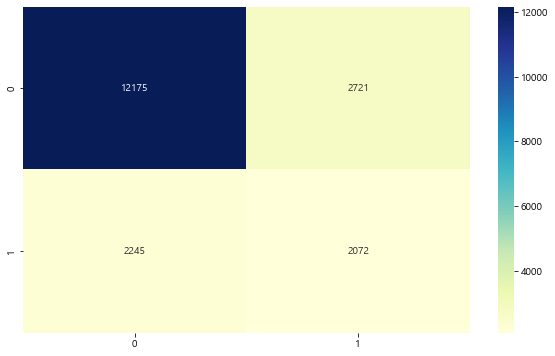

In [161]:
y_pred = (lgbm.predict_proba(X_test)[:,1] > 0.49).astype(int)
cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
fig,ax = plt.subplots(figsize = (10,6))

sns.heatmap(cm, annot=True, fmt="d", cmap='YlGnBu')